# Lineage plots

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = True

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
FIG_SVG = os.path.join(os.path.abspath(os.path.curdir), '{}.svg')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


Imports for the analysis

In [3]:
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

from gists.models import Sentence, Tree, GistsConfiguration

from analysis.utils import pairwise, memoized

sb.set()
config = GistsConfiguration.get_solo()

## 2 Plotting branch trajectories

In [4]:
def find_bin(bounds, n_bins, value):
    if np.isnan(value):
        return -1
    lower, upper = bounds
    assert lower <= value <= upper
    if value == upper:
        return n_bins - 1
    bins = np.linspace(lower, upper, n_bins + 1)
    return np.where(bins <= value)[0][-1]

In [5]:
@memoized
def token_directed_path_length(head, sentence, tid, direction, cutoff=True):
    assert direction in ['up', 'down']
    
    if direction == 'up':
        if sentence.parent is None:
            return 0
        parent, child = sentence.parent, sentence
    if direction == 'down':
        if (sentence.children.kept.count() == 0
                or (cutoff and sentence.depth >= config.target_branch_depth)):
            return 0
        if sentence.parent is None:
            parent, child = sentence, head
        else:
            parent, child = sentence, sentence.children.kept.first()
    
    del_ids, ins_ids, rpl_pairs, stb_pairs = parent.consensus_relationships(child)
    if direction == 'up':
        if tid in ins_ids:
            return 0
        child2parent = dict((cid, pid) for (pid, cid) in itertools.chain(rpl_pairs, stb_pairs))
        return 1 + token_directed_path_length(head, parent, child2parent[tid], 'up')
    else:
        assert direction == 'down'
        if tid in del_ids:
            return 0
        parent2child = dict(itertools.chain(rpl_pairs, stb_pairs))
        return 1 + token_directed_path_length(head, child, parent2child[tid], 'down')

def token_path_length(head, sentence, tid, cutoff=True):
    return (token_directed_path_length(head, sentence, tid, 'up', cutoff=cutoff)
            + token_directed_path_length(head, sentence, tid, 'down', cutoff=cutoff))

In [6]:
transformation_width = .5
exchange_lag = transformation_width / 3
indel_lag = transformation_width / 4
blue, green, red, purple, yellow, cyan = sb.color_palette()

def plot_branch(bid, **kwargs):
    ax = kwargs.get('ax', plt.gca())
    coloring = kwargs.get('coloring', None)
    assert coloring in ['frequency', 'path_length', None]
    head = Sentence.objects.get(id=bid)
    tree = head.tree
    
    # Prepare colours
    if coloring is None:
        
        def color(head, sentence, tid):
            return 'lightgrey'
        
    elif coloring == 'frequency':
        
        all_freq_bounds = np.array([[np.nanmin(sentence.features('zipf_frequency')),
                                     np.nanmax(sentence.features('zipf_frequency'))]
                                    for sentence in tree.sentences.kept])
        freq_bounds = (np.nanmin(all_freq_bounds), np.nanmax(all_freq_bounds))
        #freq_palette = sb.cubehelix_palette(8, start=3, rot=-.3) + [[0, 0, 0]]
        freq_palette = sb.light_palette("grey", 10)[2:] + [[0, 0, 0]]
        
        def color(head, sentence, tid):
            return freq_palette[find_bin(freq_bounds, 8,
                                         sentence.features('zipf_frequency')[tid])]
    
    else:
    
        assert coloring == 'path_length'
        path_palette = sb.light_palette("grey", config.target_branch_depth + 1 + 1)[1:]
        
        def color(head, sentence, tid):
            return path_palette[token_path_length(head, sentence, tid)]
    
    # Plot the lineages
    for parent, child in pairwise(head.branch_sentences(with_root=True, with_leaf=True)):
        del_ids, ins_ids, rpl_pairs, stb_pairs = parent.consensus_relationships(child)
        # Plot deletions
        for did in del_ids:
            ax.plot([parent.depth,
                     parent.depth + 1 - transformation_width + indel_lag],
                    [did] * 2,
                    color=color(child.head, parent, did))
            ax.plot(parent.depth + 1 - transformation_width + indel_lag, did,
                    marker='o', markersize=5, color=red, zorder=999999)
        # Plot insertions
        for iid in ins_ids:
            ax.plot([child.depth - indel_lag,
                     child.depth + ((child.depth == config.target_branch_depth)
                                    * (1 - transformation_width))],
                    [iid] * 2,
                    color=color(child.head, child, iid))
            ax.plot(child.depth - indel_lag, iid,
                    marker='o', markersize=5, color=green, zorder=999999)
        # Plot replacements
        for pid, _ in rpl_pairs:
            ax.plot(parent.depth + 1 - transformation_width + exchange_lag, pid,
                    marker='o', markersize=5, color='dodgerblue', zorder=999999)
        # Plot links
        for pid, cid in itertools.chain(stb_pairs, rpl_pairs):
            ax.plot([parent.depth,
                     parent.depth + 1 - transformation_width + exchange_lag],
                    [pid] * 2,
                    color=color(child.head, parent, pid))
            ax.plot([parent.depth + 1 - transformation_width + exchange_lag,
                     child.depth - exchange_lag],
                    [pid, cid],
                    color=color(child.head, parent, pid))
            ax.plot([child.depth - exchange_lag,
                     child.depth + ((child.depth == config.target_branch_depth)
                                    * (1 - transformation_width))],
                    [cid] * 2,
                    color=color(child.head, parent, pid))
    
    # Plot the backgrounds and legend
    for i in range(config.target_branch_depth + 1):
        ax.axvspan(i, i + 1 - transformation_width, facecolor='0.5', alpha=.05)
    ax.set_xlim(0, config.target_branch_depth + (1 - transformation_width) / 2)
    ax.set_xticks(range(config.target_branch_depth + 1))
    ax.grid(axis='x')
    ax.set_facecolor((0.98, 0.98, 1, 1.0))
    ax.text(config.target_branch_depth,
            .95 * max(len(sentence.tokens) for sentence in tree.sentences.kept),
           'Branch #{}'.format(bid),
           ha='right', va='top',
           bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
    ax.set_xlabel('$d$')
    ax.set_ylabel('Index of $w$ in $u$')

In [7]:
def plot_tree(tid, title=True, branch_kws={}):
    tree = Tree.objects.get(id=tid)
    branch_count = tree.root.children.kept.count()
    max_tokens_count = max(len(sentence.tokens) for sentence in tree.sentences.kept)
    fig, axes = plt.subplots(branch_count, 1,
                             figsize=(12, branch_count * max_tokens_count * .08),
                             sharey=True, sharex=True)
    for i, head in enumerate(tree.root.children.kept):
        if i == 0 and title:
            axes[i].set_title('Tree #{}'.format(tid))
        plot_branch(head.id, ax=axes[i], **branch_kws)
        if i < branch_count - 1:
            axes[i].set_xlabel('')
    fig.tight_layout()
    return fig

In [8]:
Tree.objects.get(id=4).root.text

'At Dover, the finale of the bailiffs\' convention. Their duties, said a speaker, are "delicate, dangerous, and insufficiently compensated."'

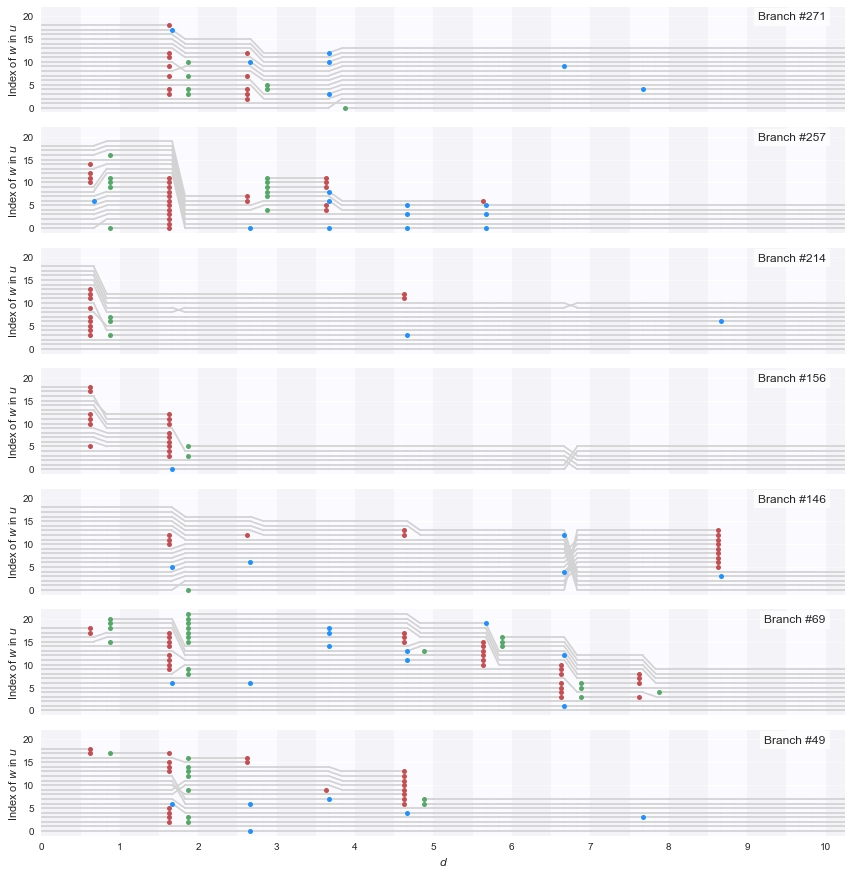

In [9]:
fig = plot_tree(4, title=False)

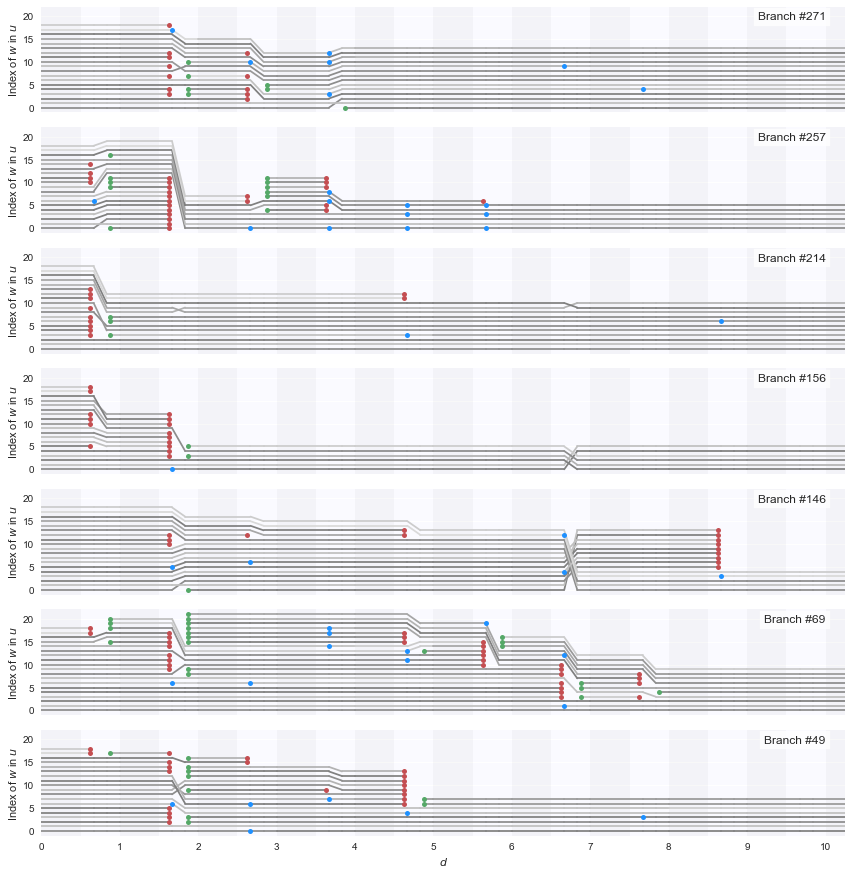

In [10]:
fig = plot_tree(4, title=False, branch_kws={'coloring': 'frequency'})

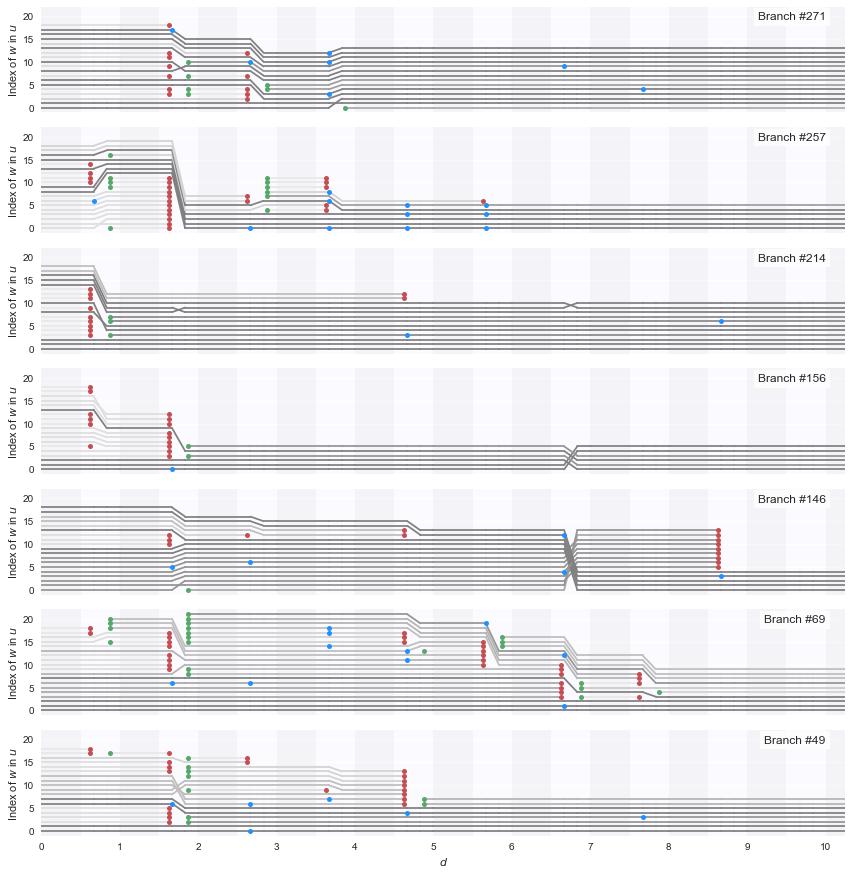

In [11]:
fig = plot_tree(4, title=False, branch_kws={'coloring': 'path_length'})
if SAVE_FIGURES:
    fig.savefig(FIG.format('lineage-tree-4'), dpi=300, bbox_inches='tight')
    fig.savefig(FIG_SVG.format('lineage-tree-4'), bbox_inches='tight')

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



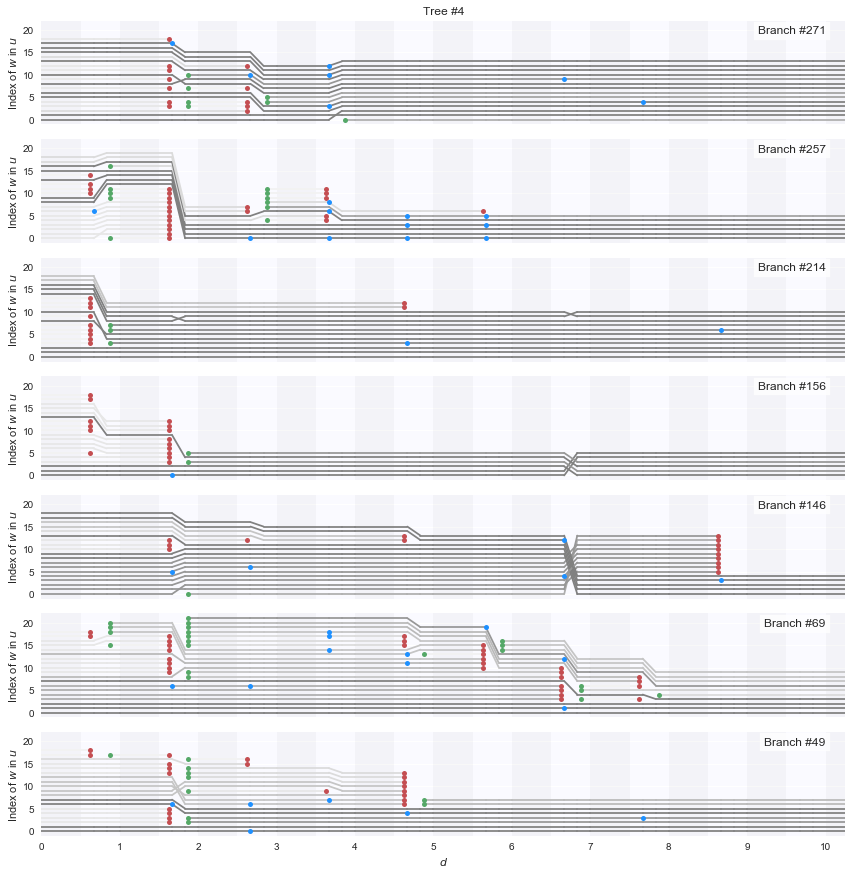

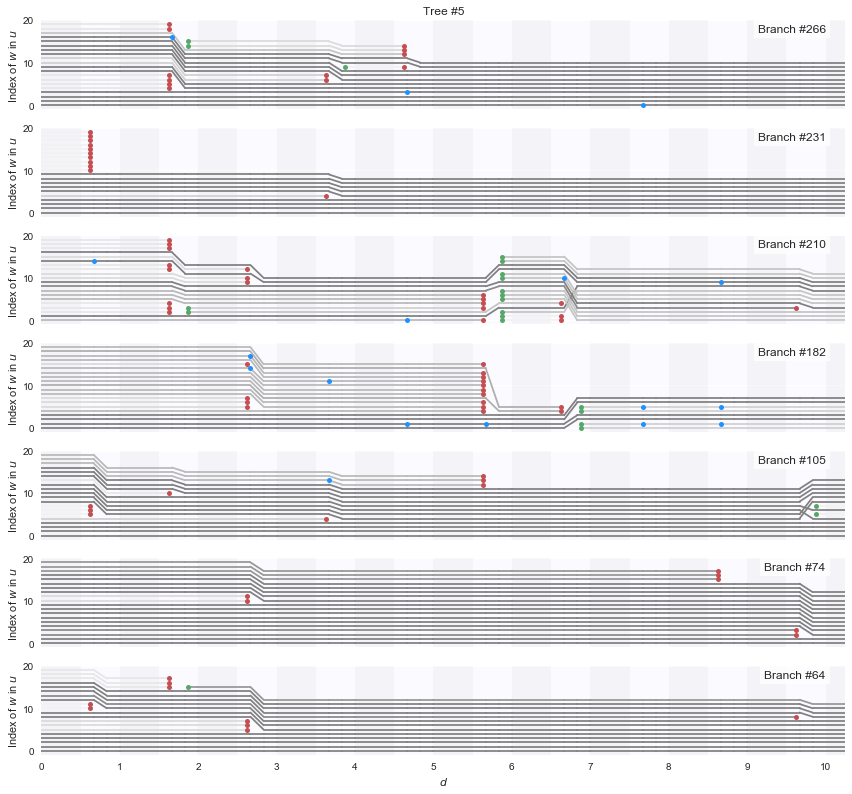

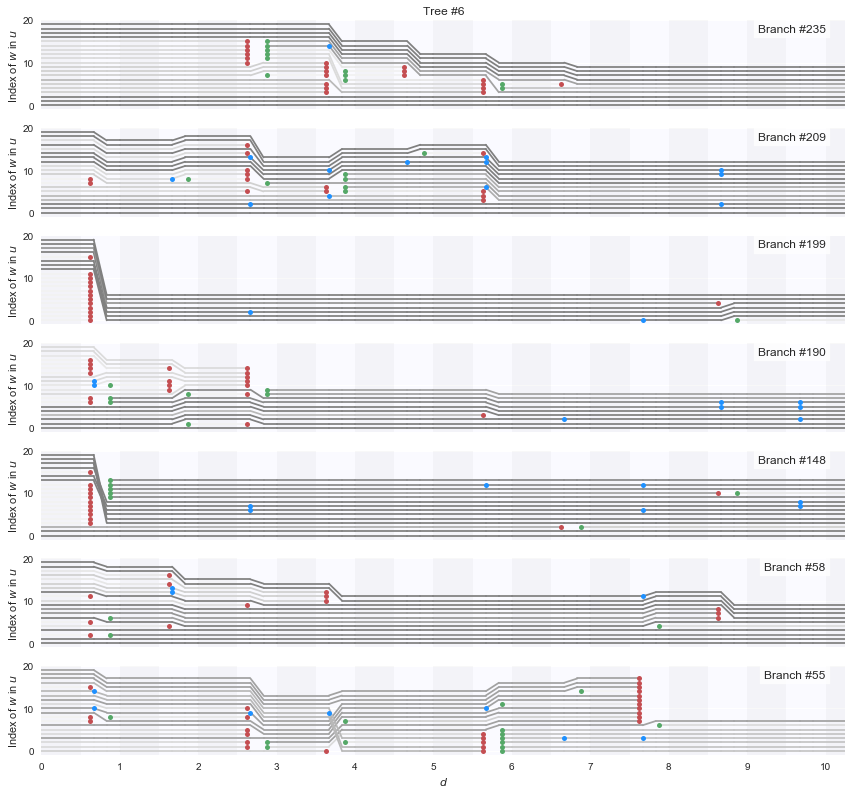

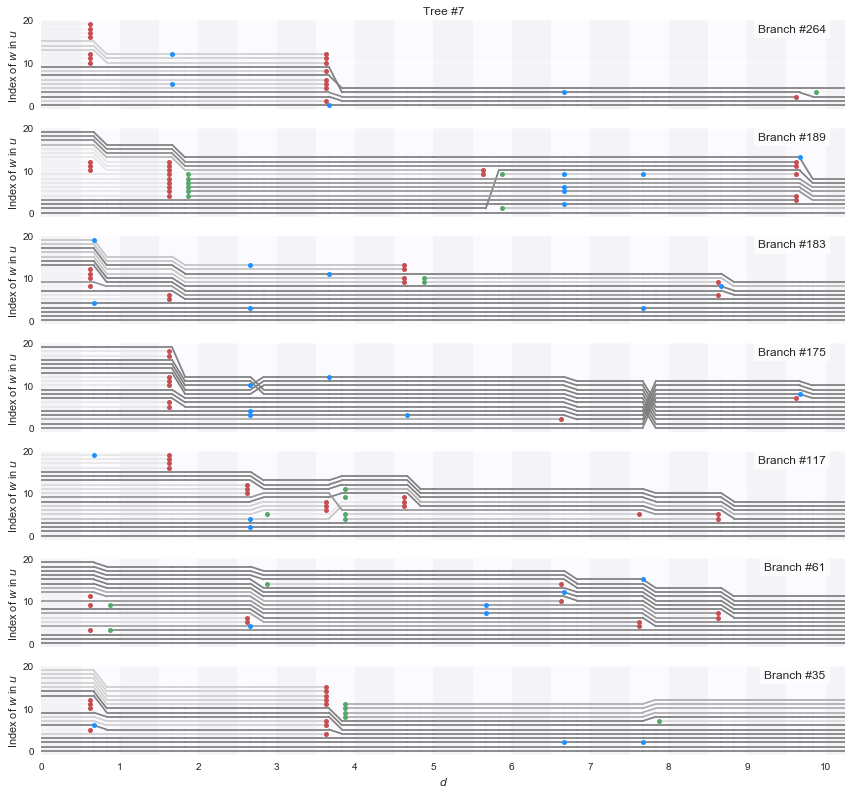

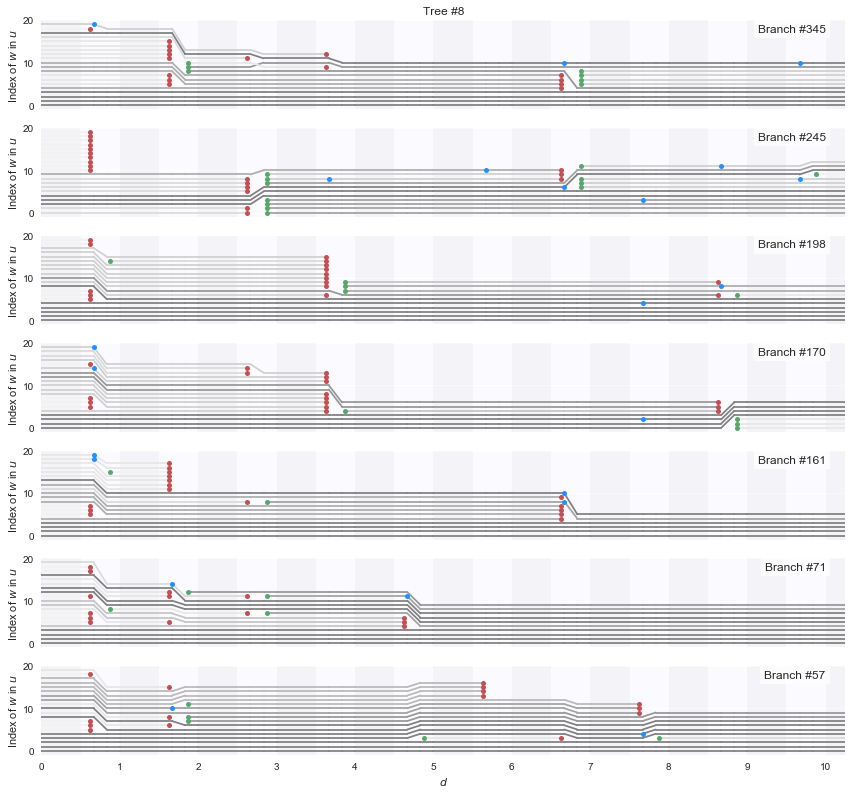

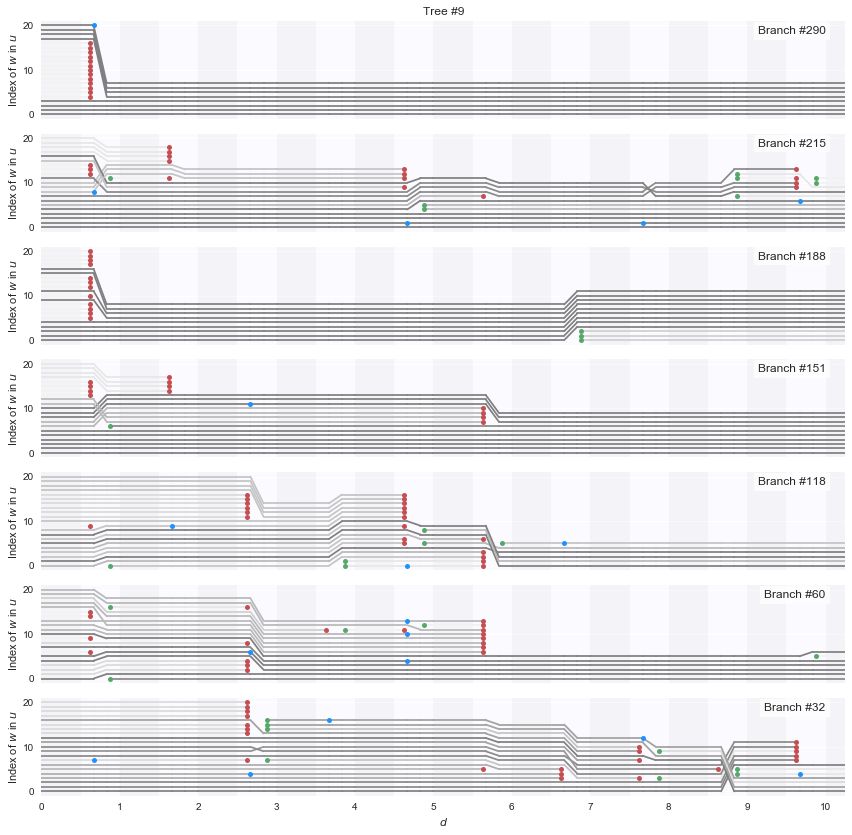

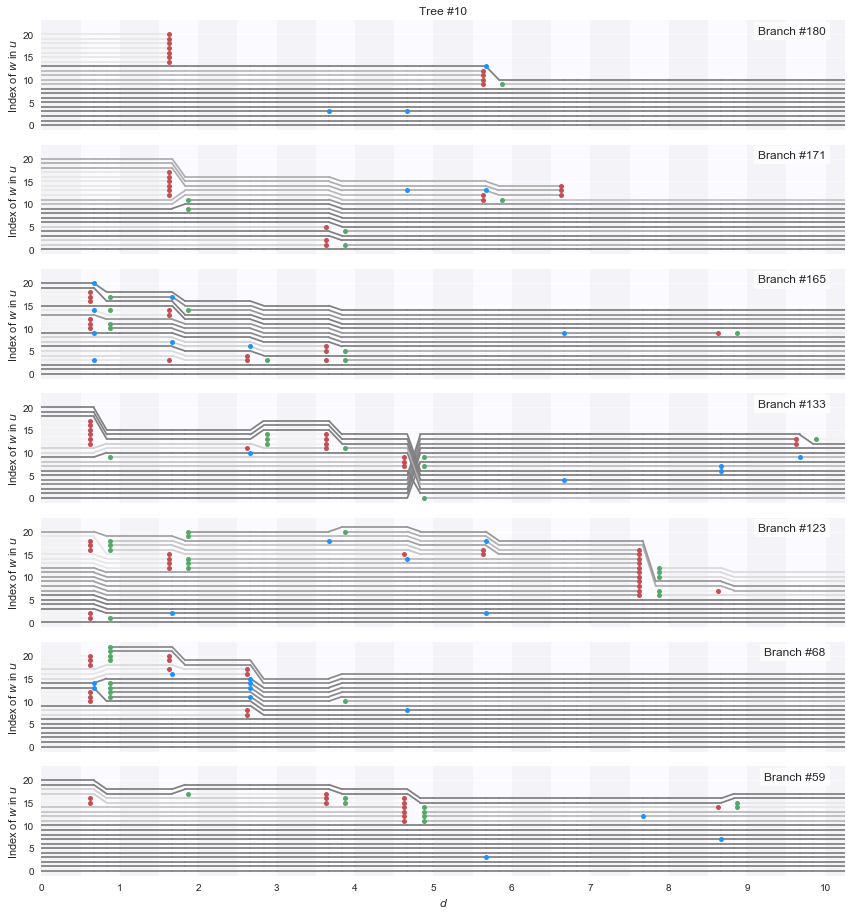

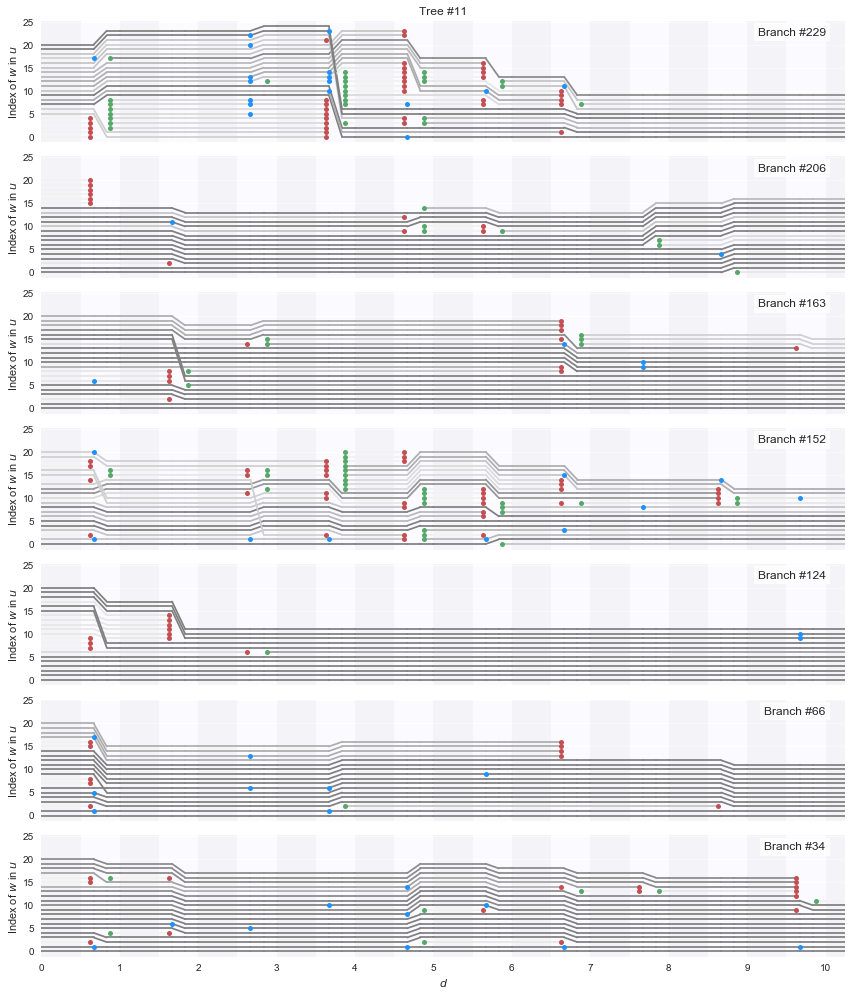

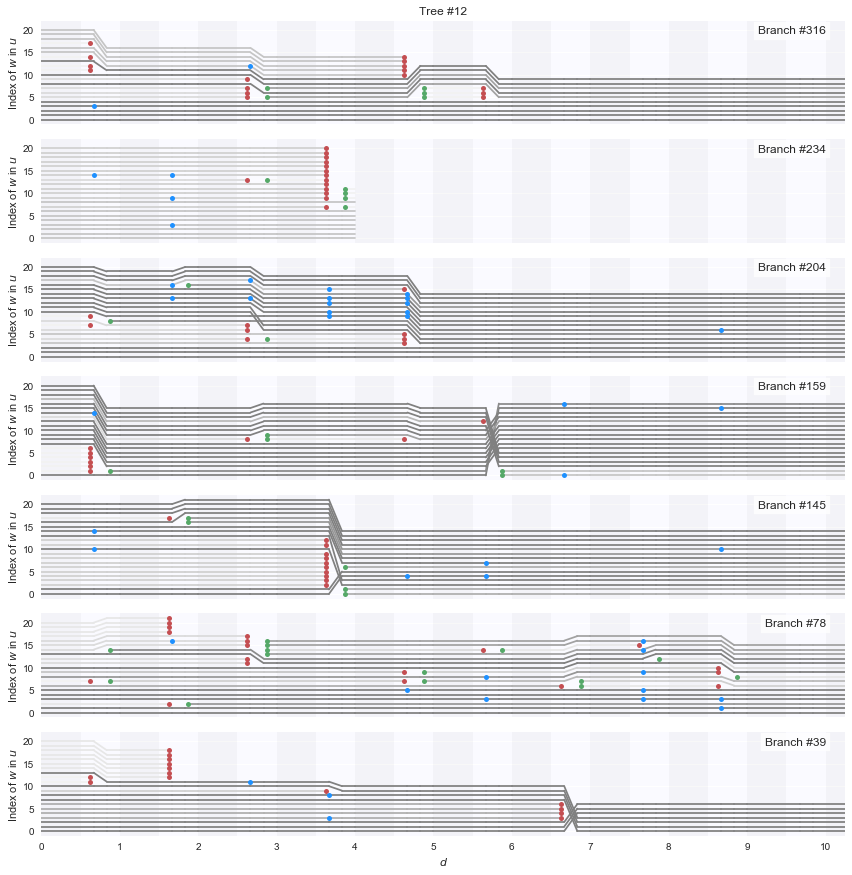

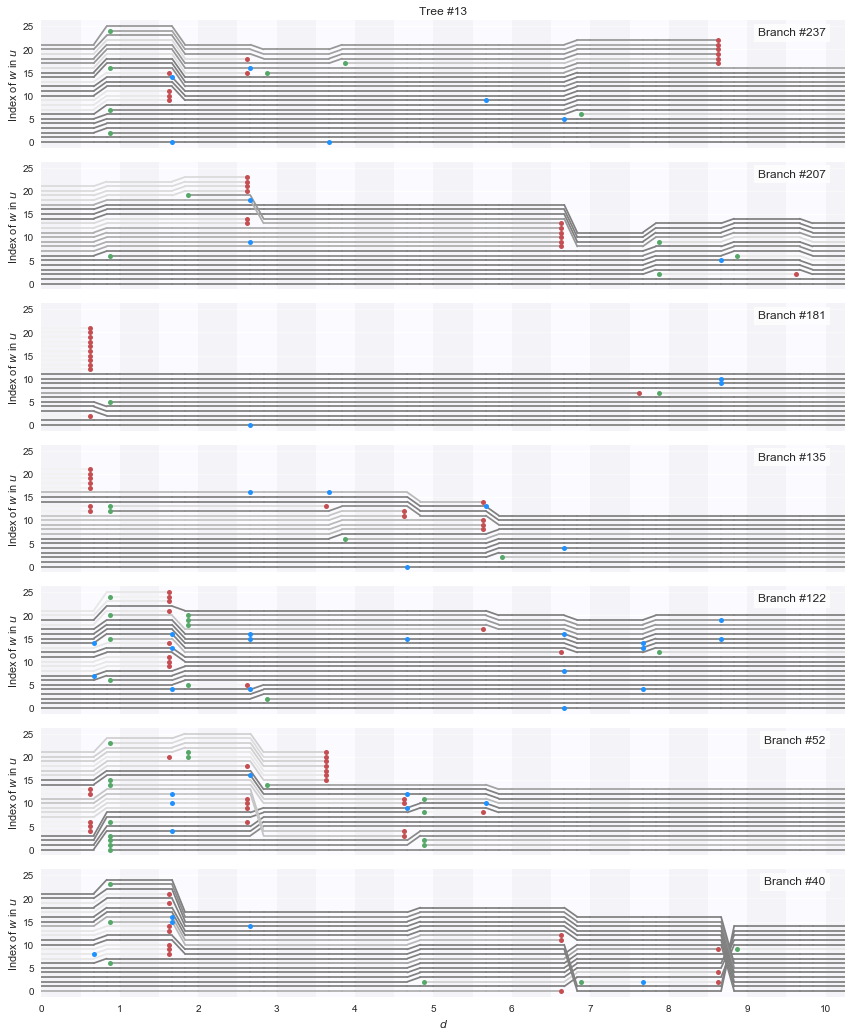

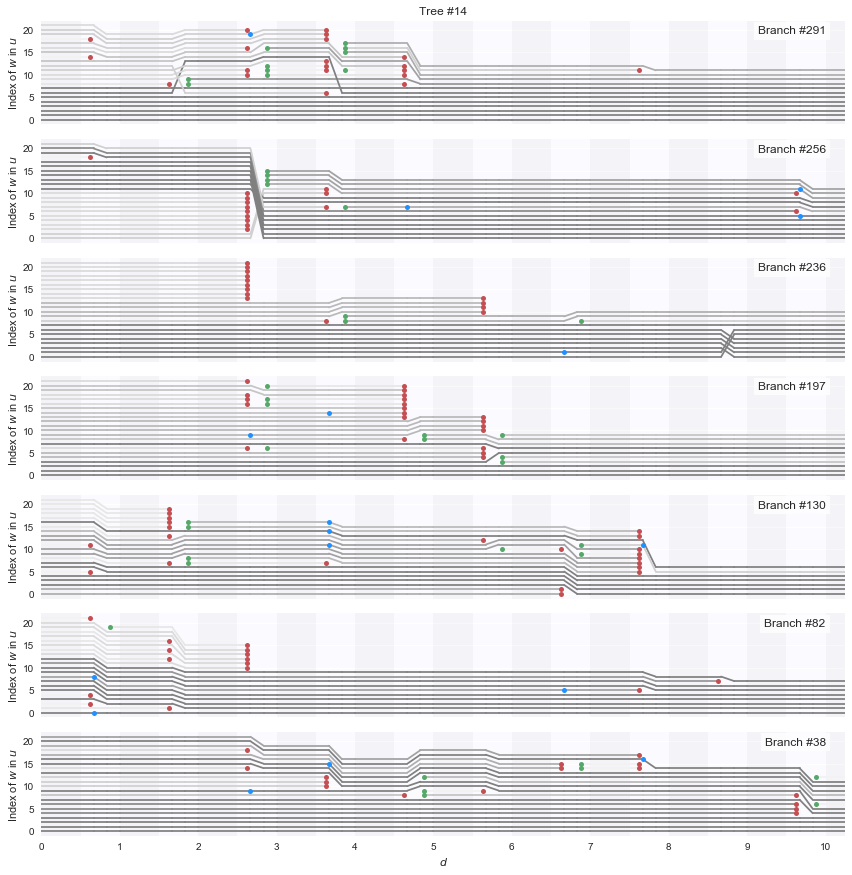

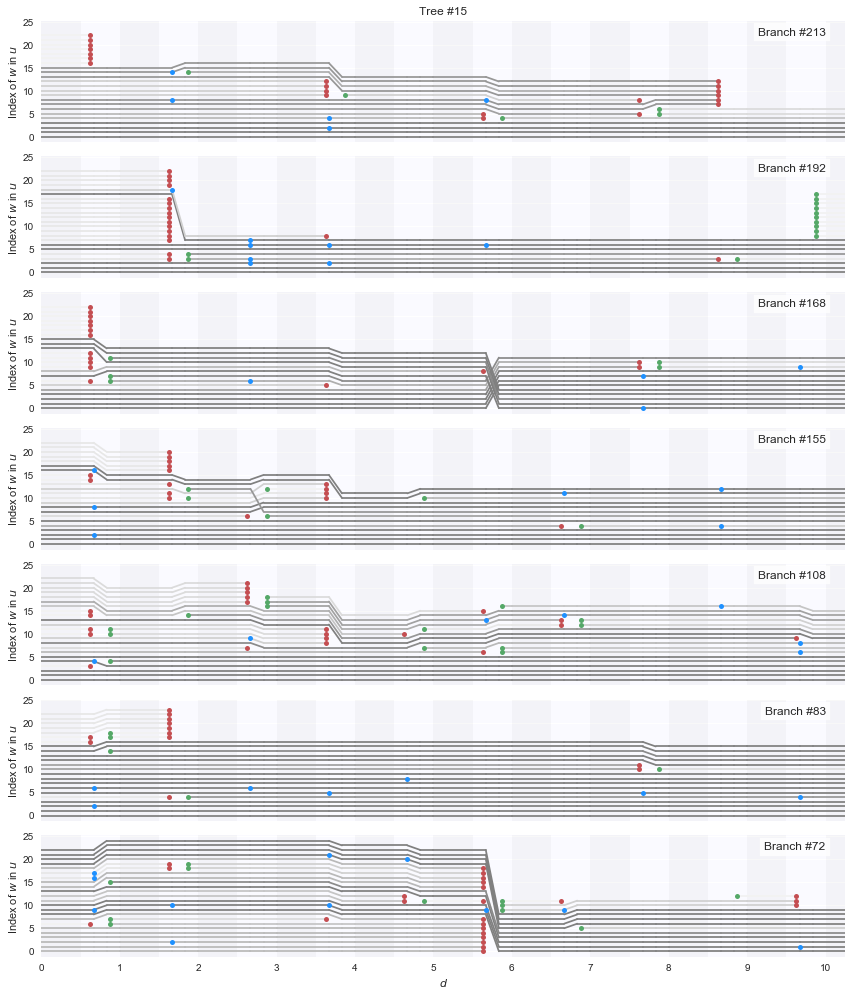

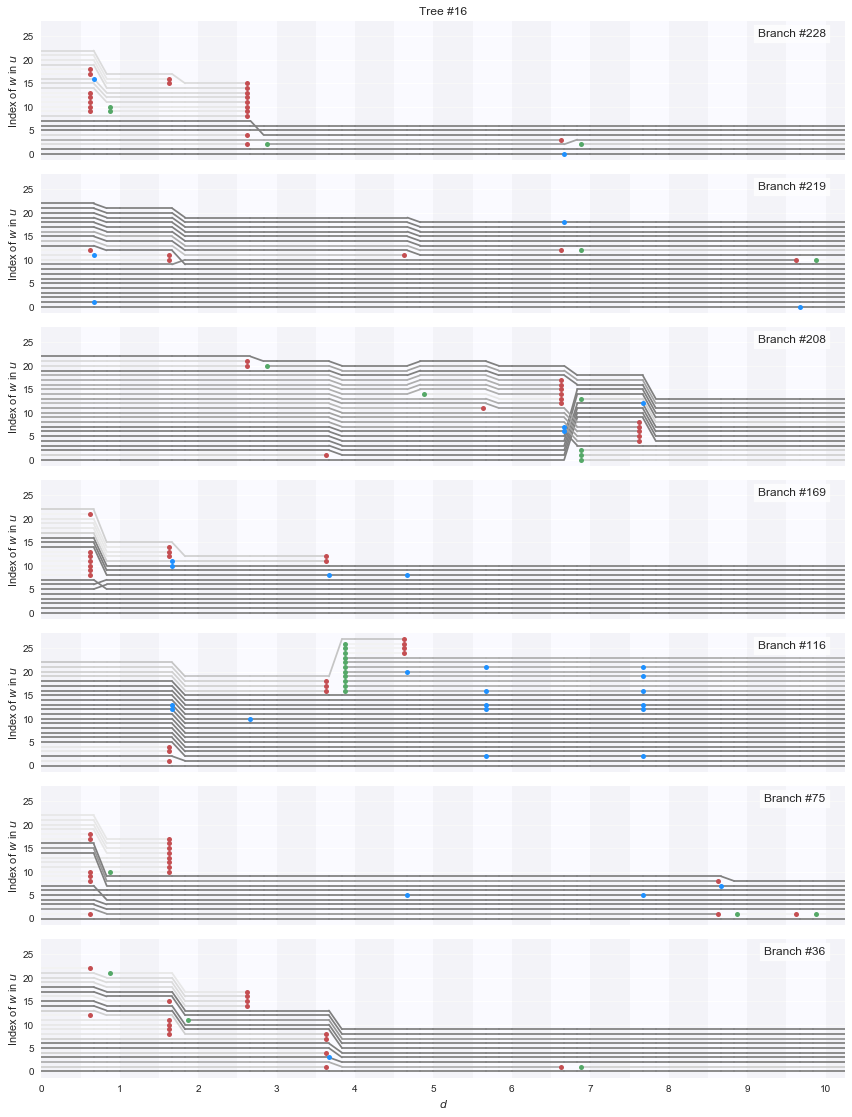

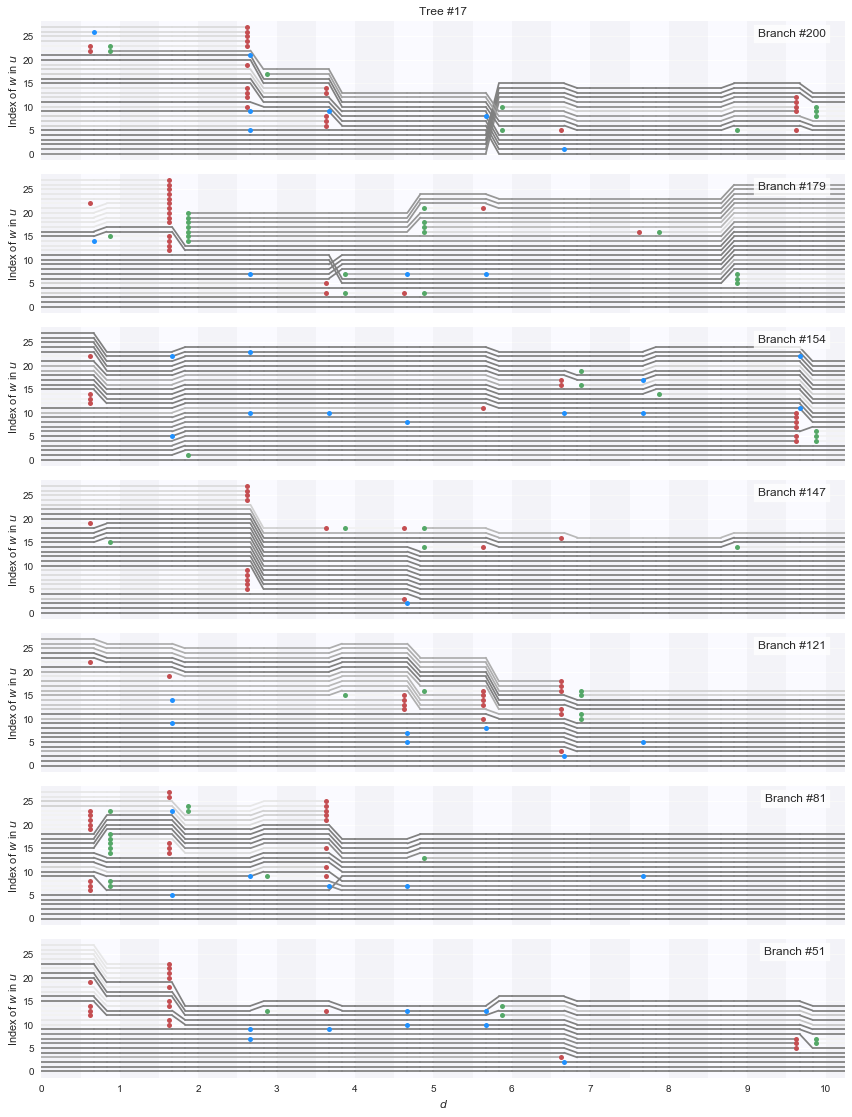

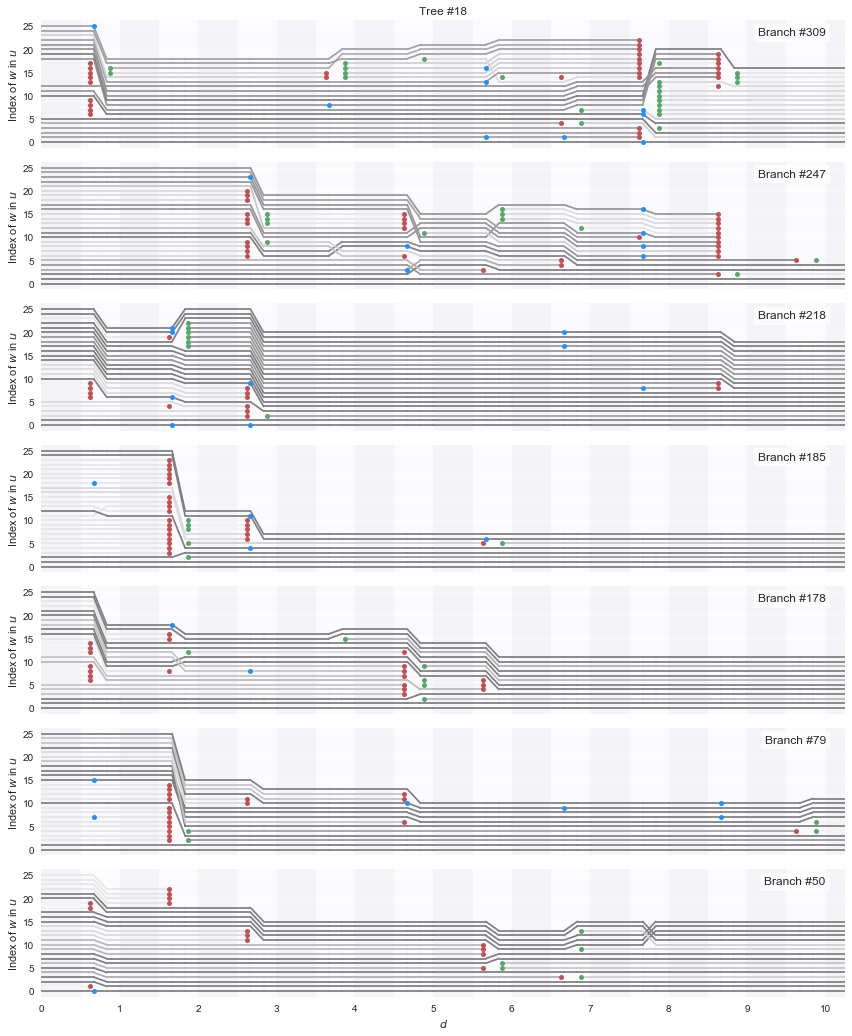

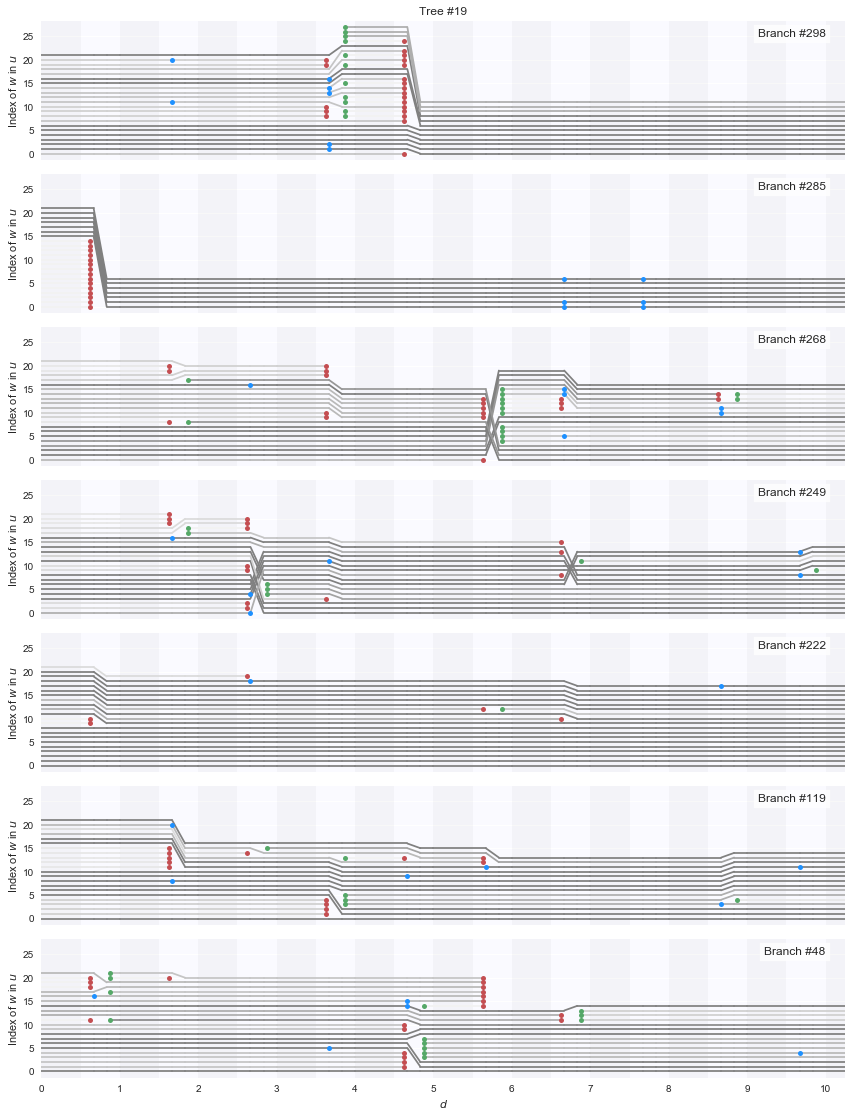

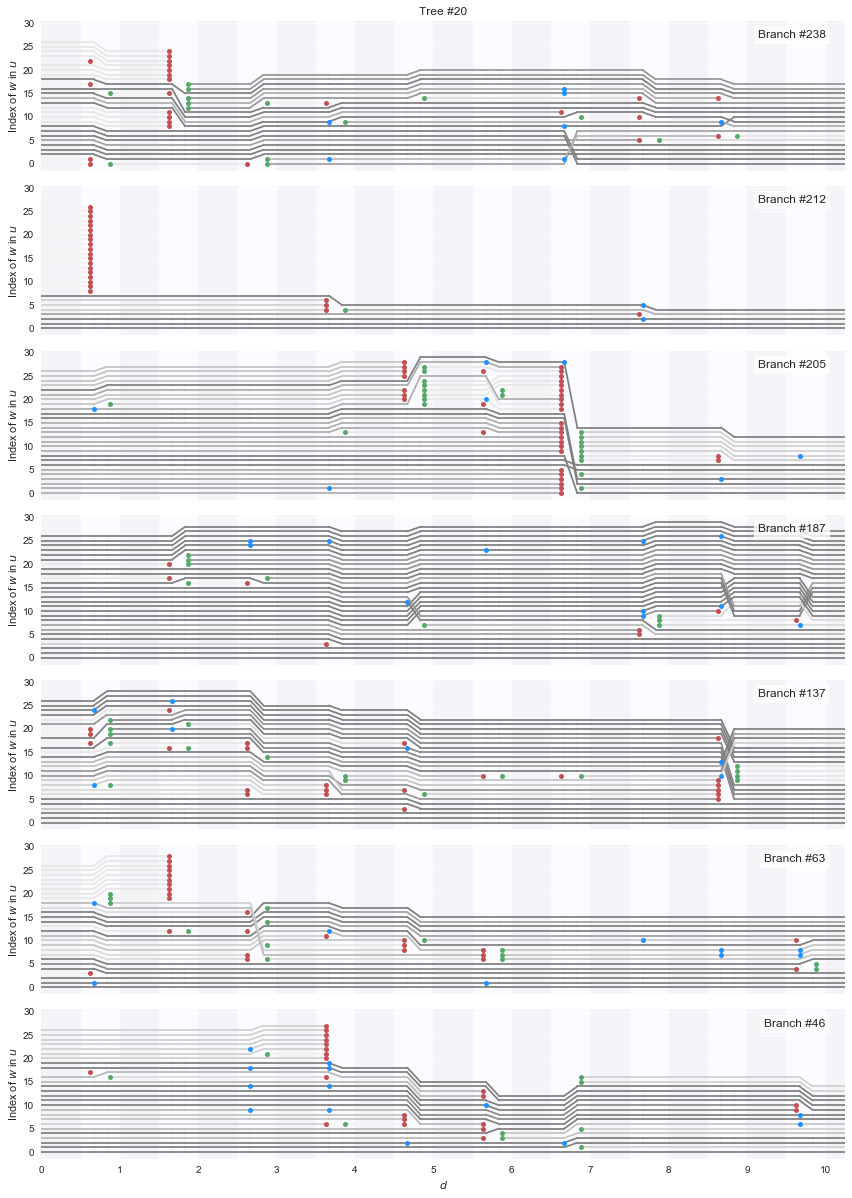

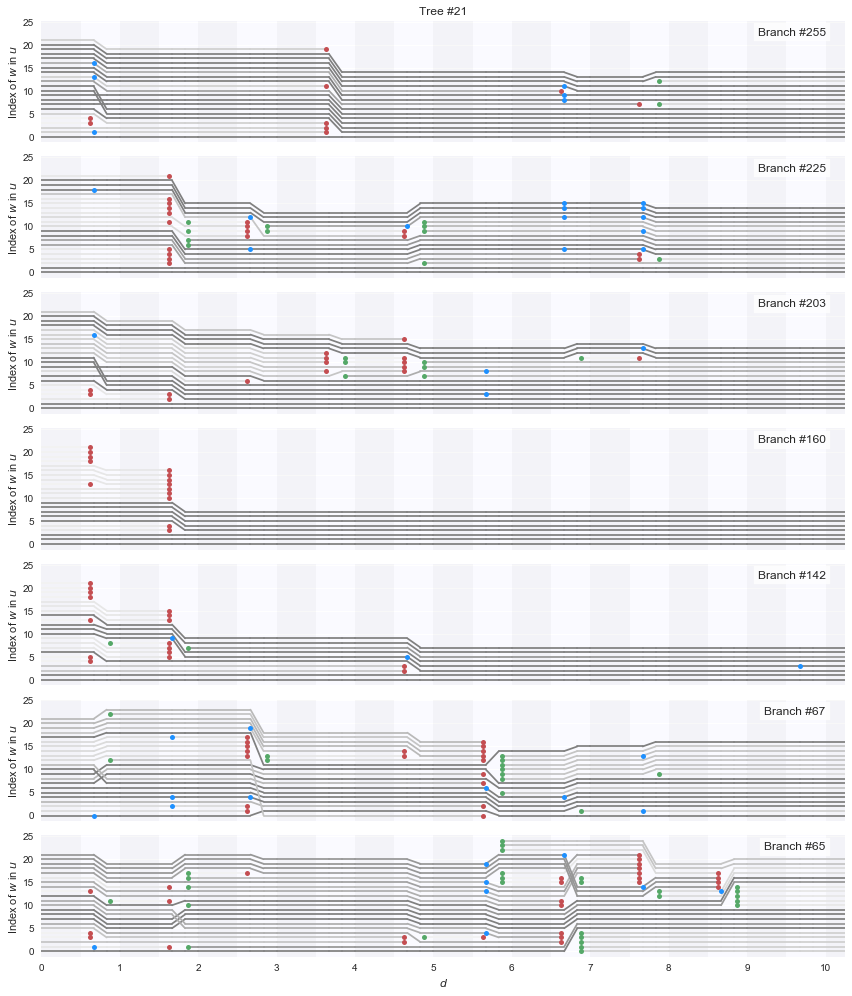

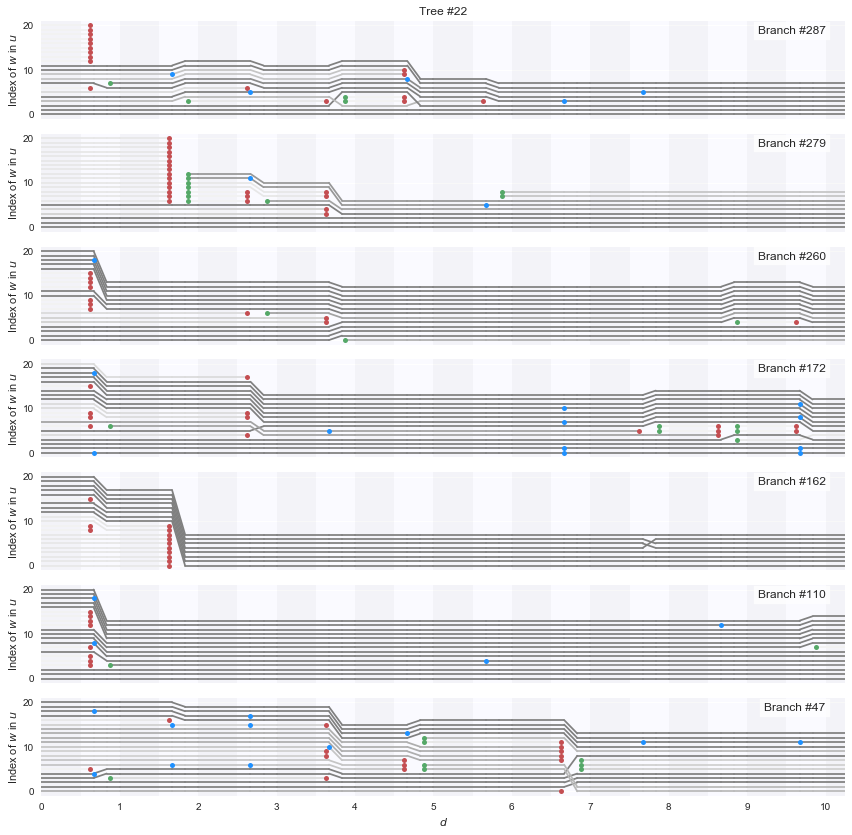

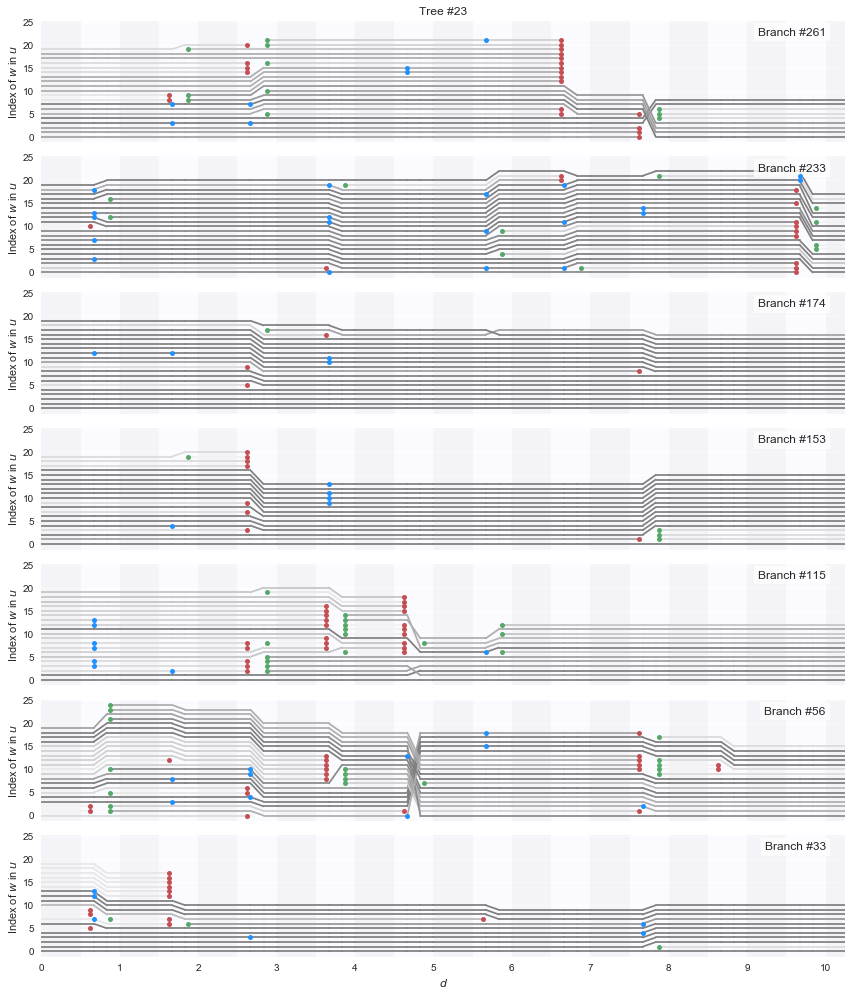

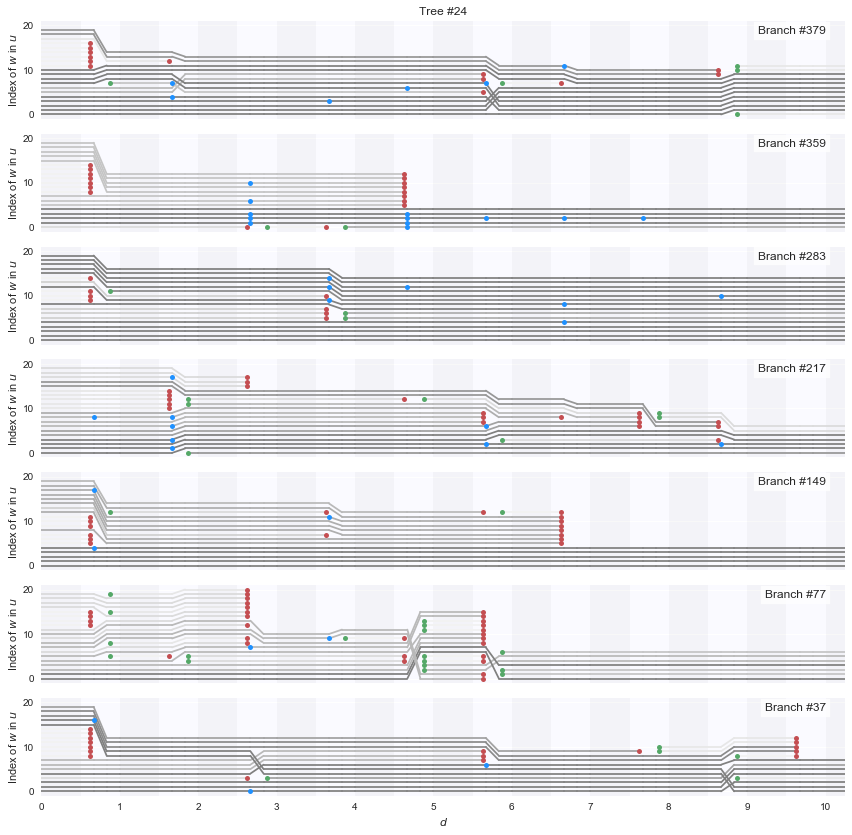

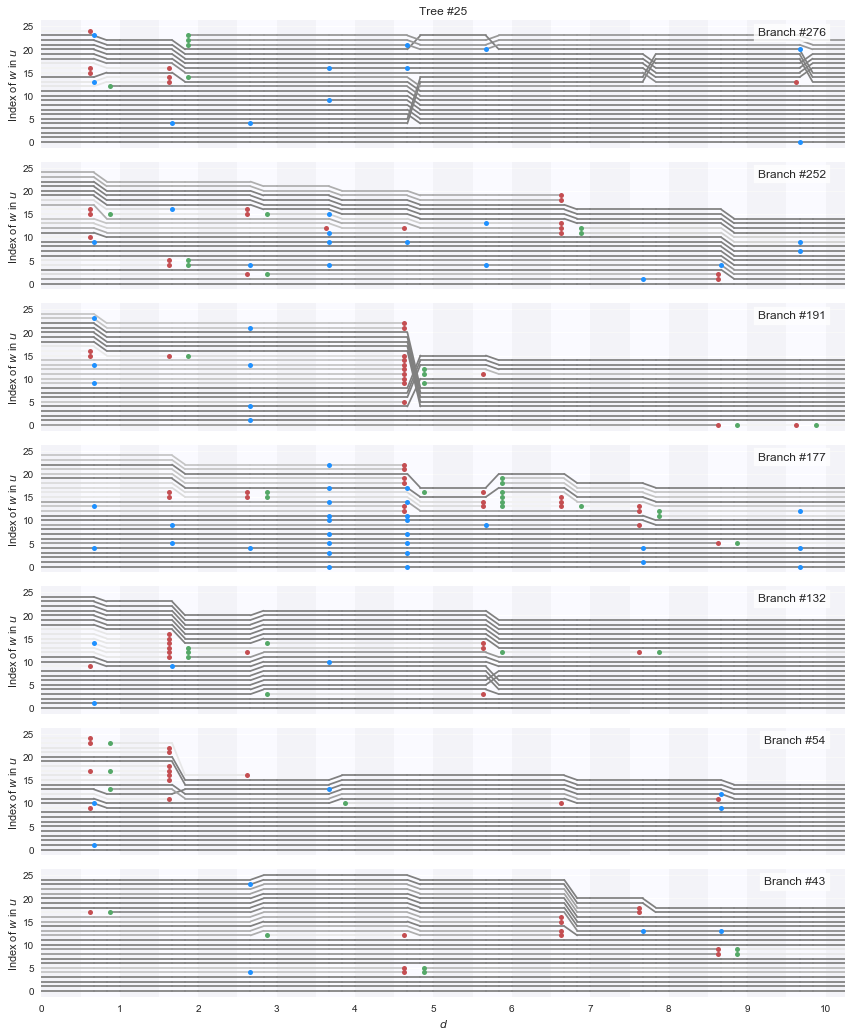

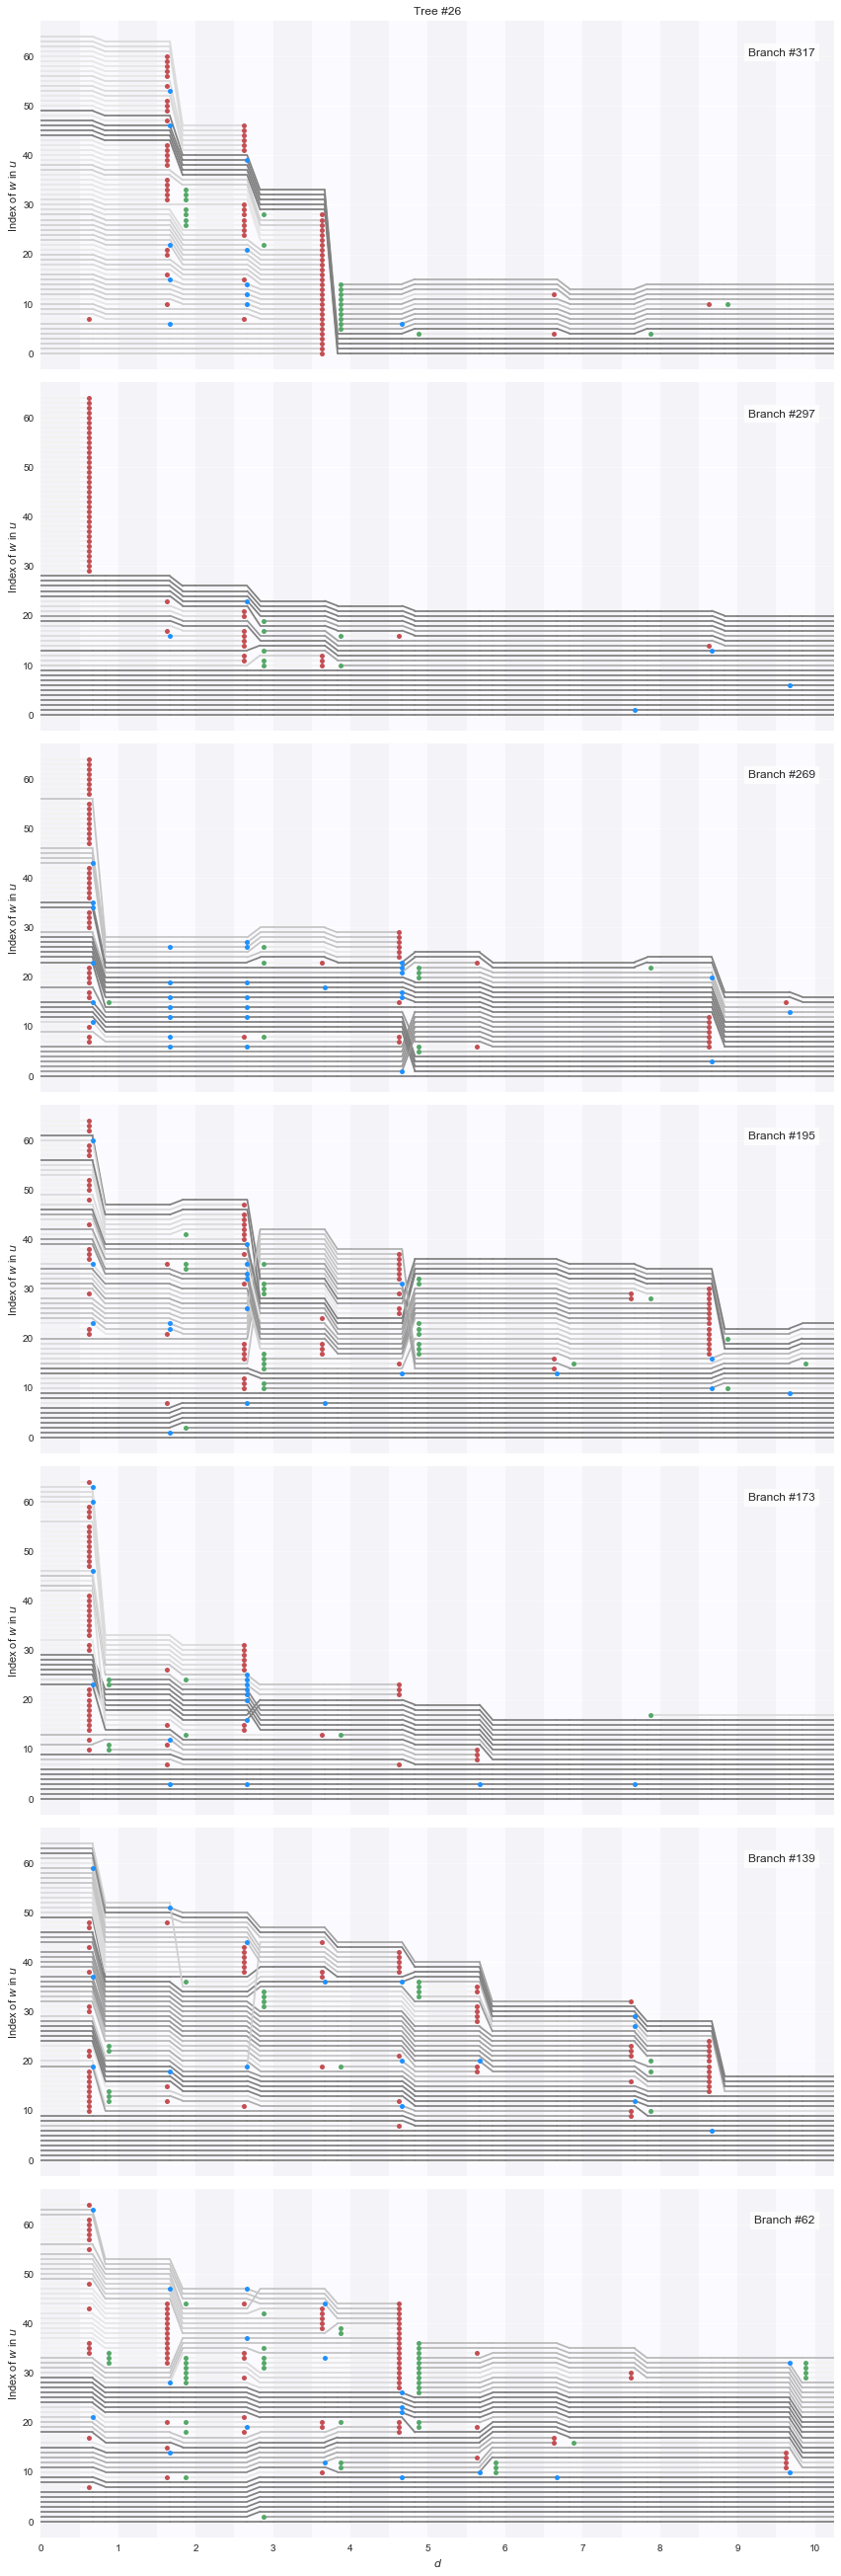

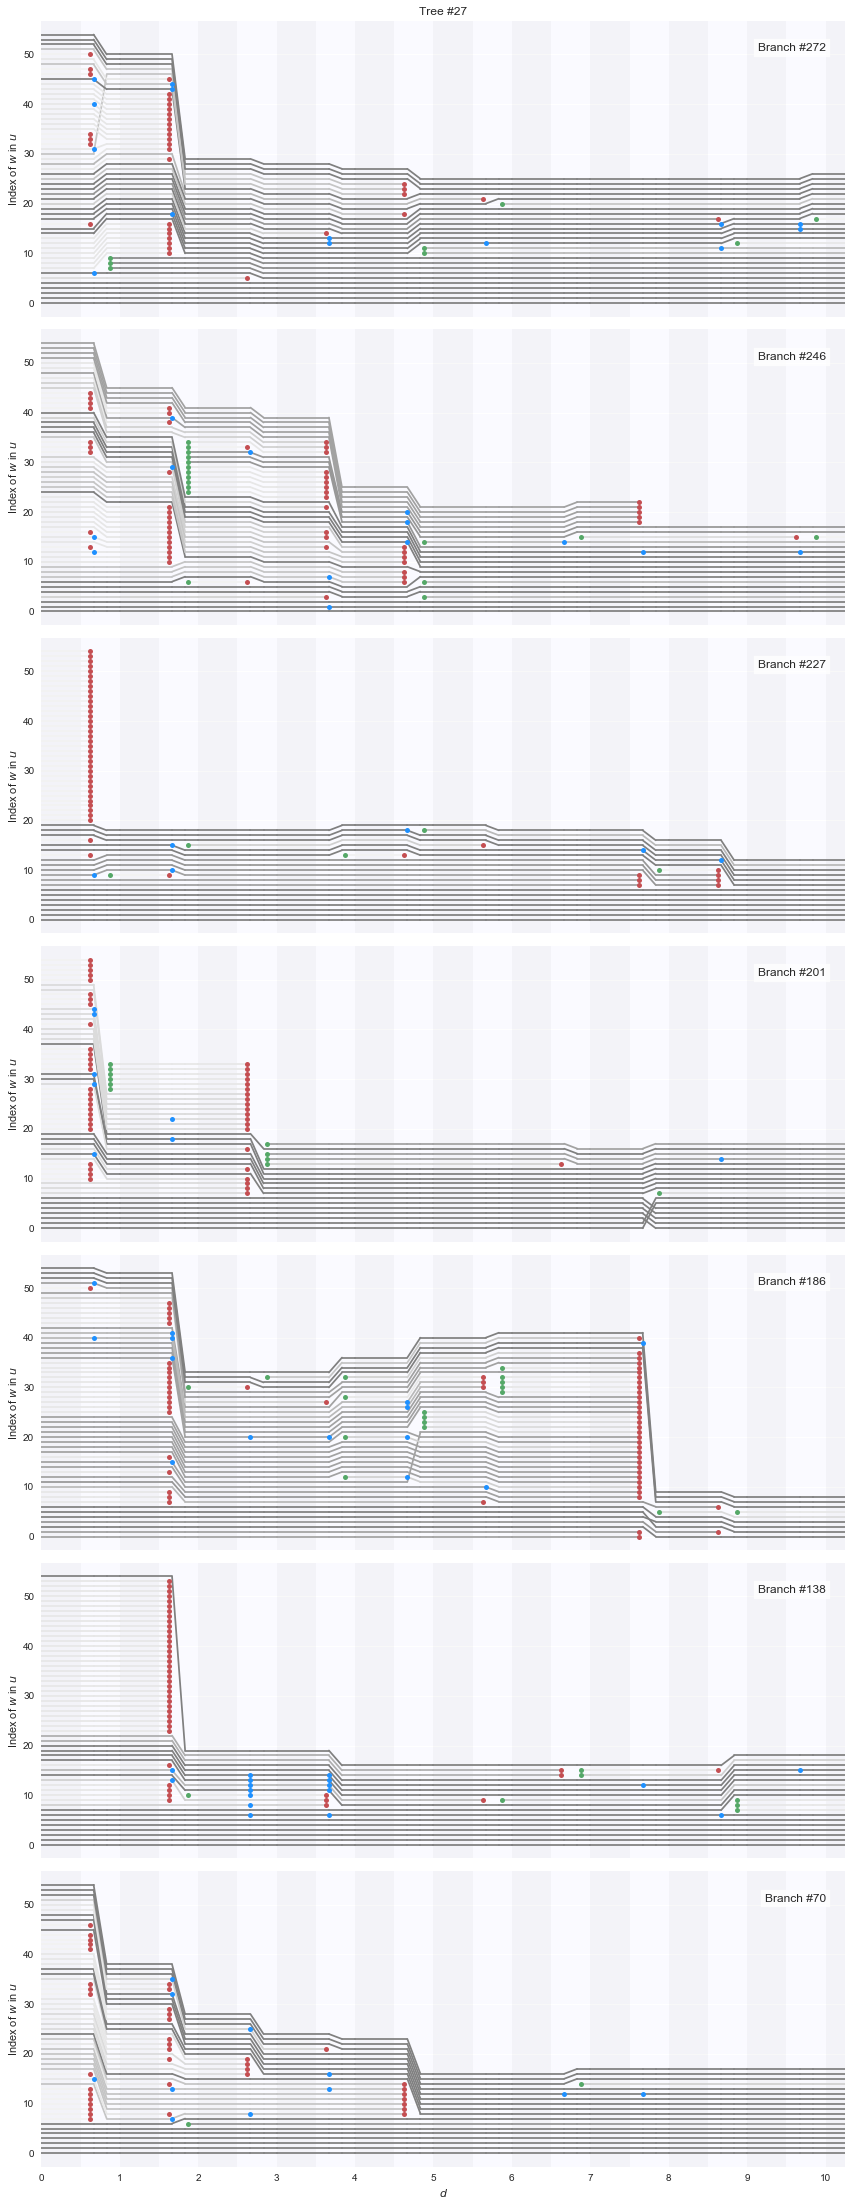

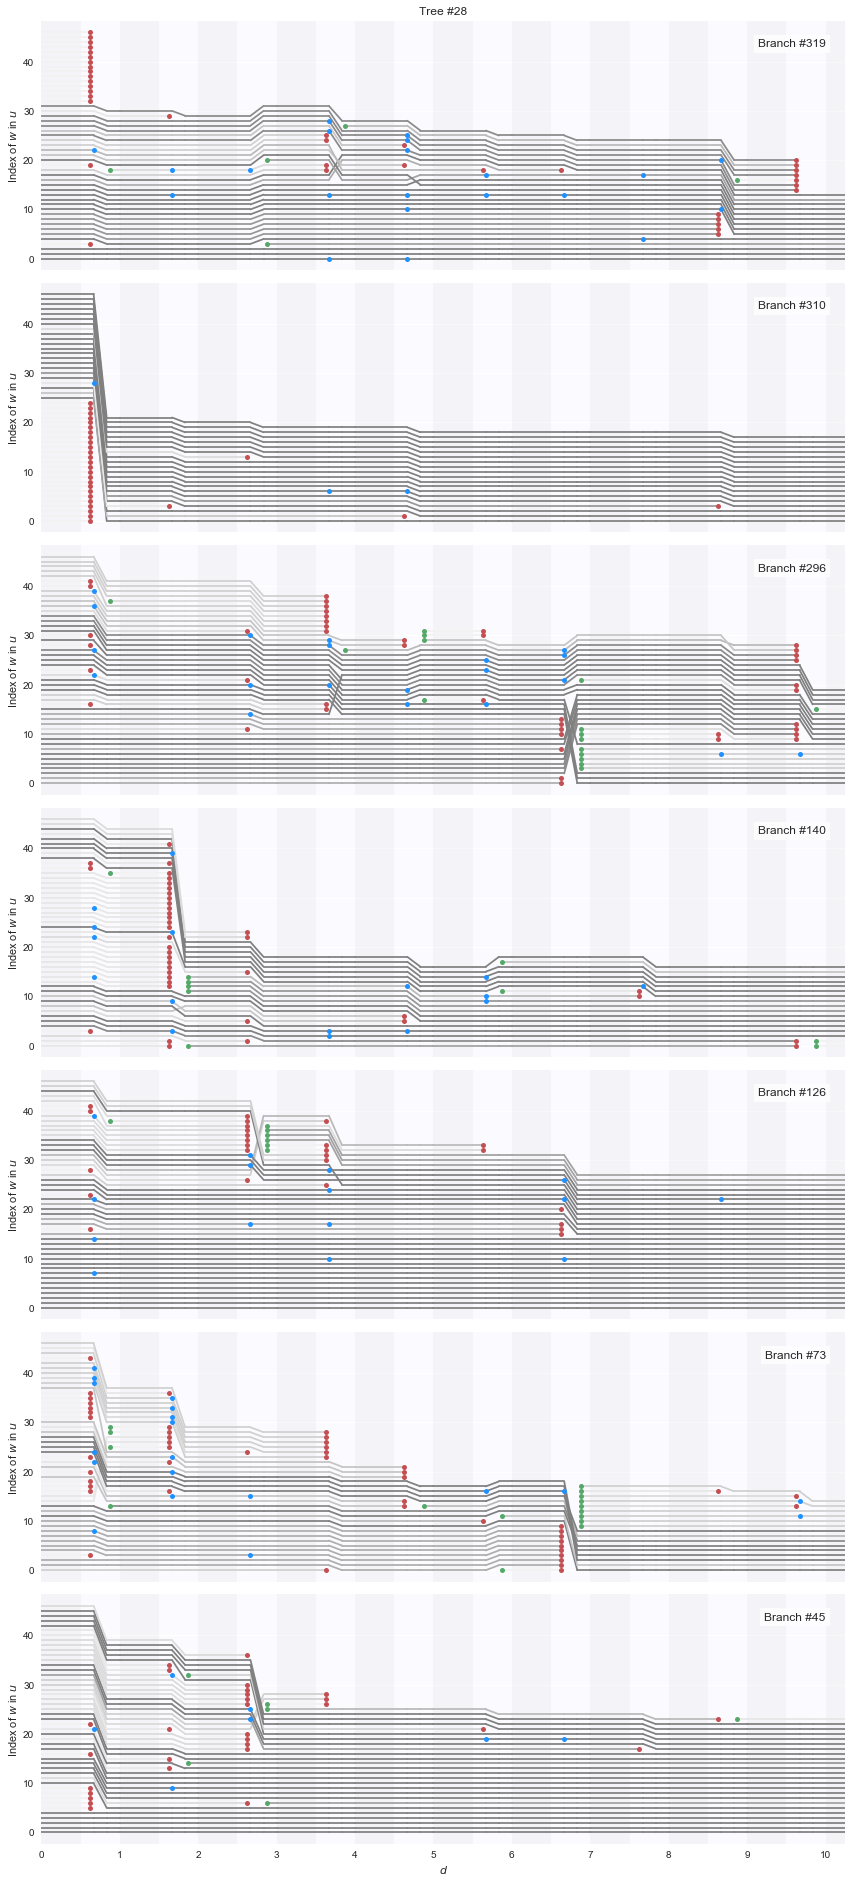

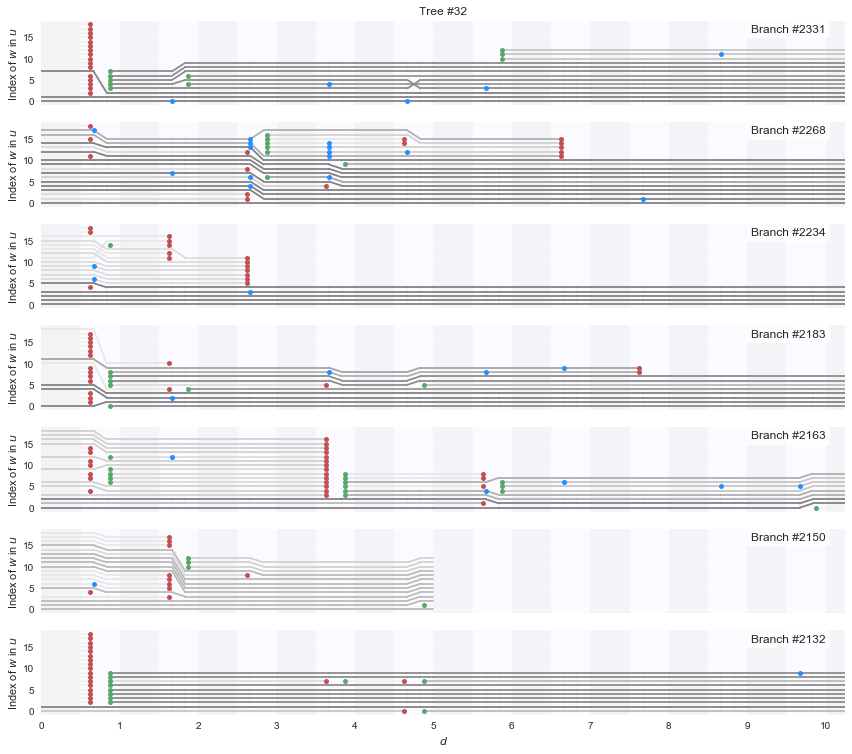

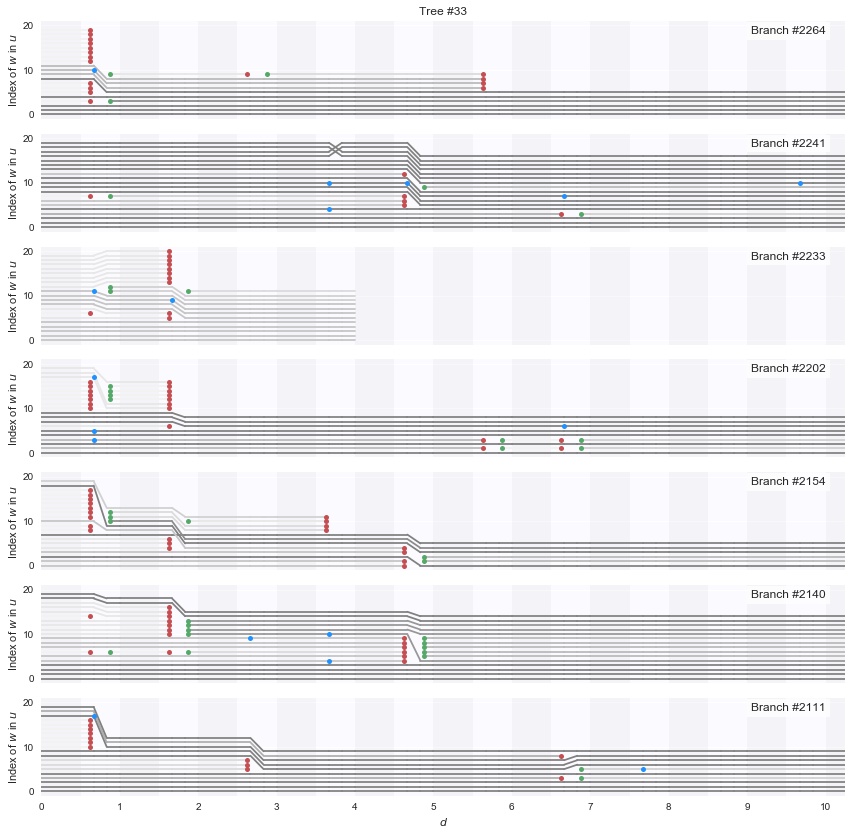

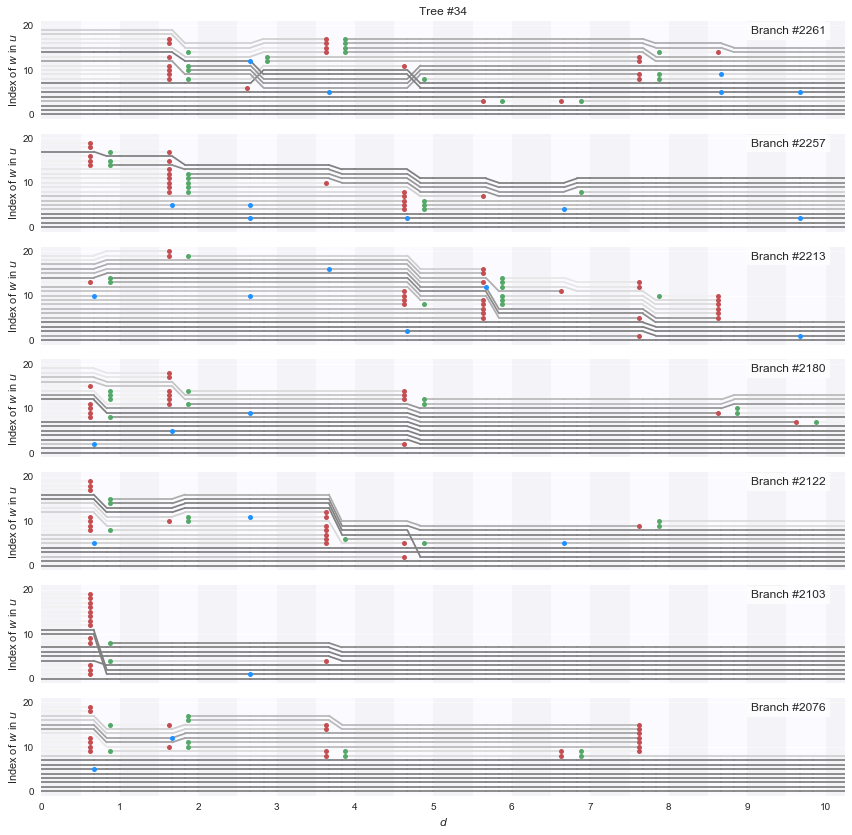

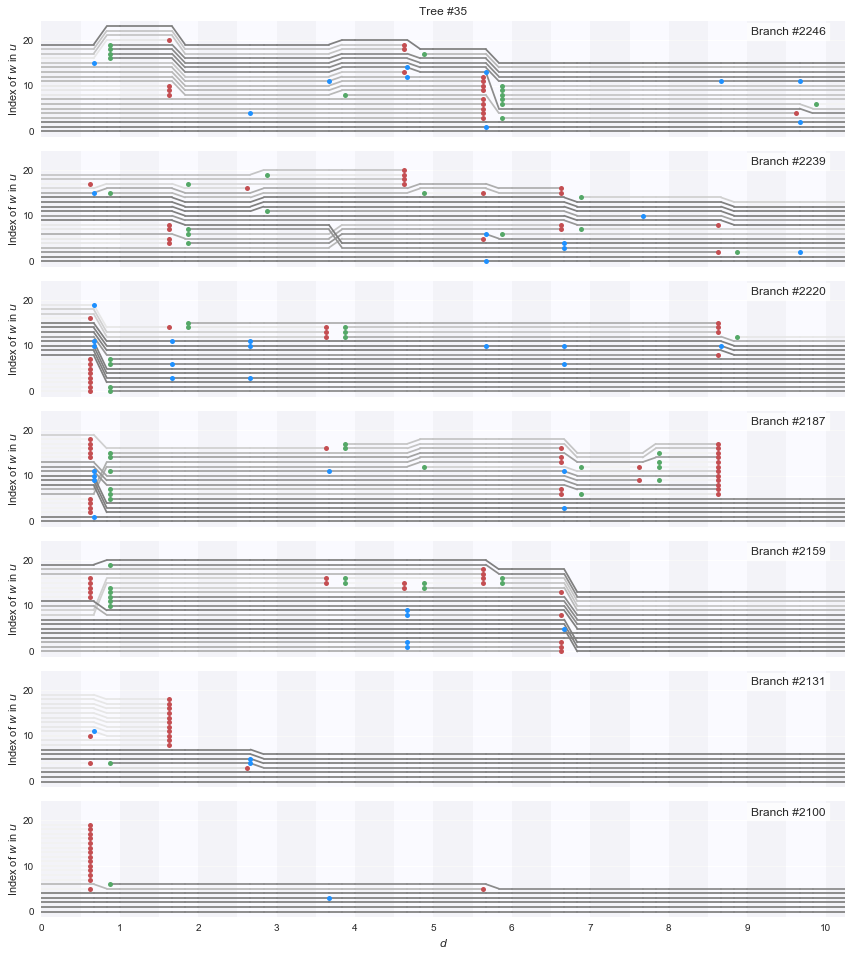

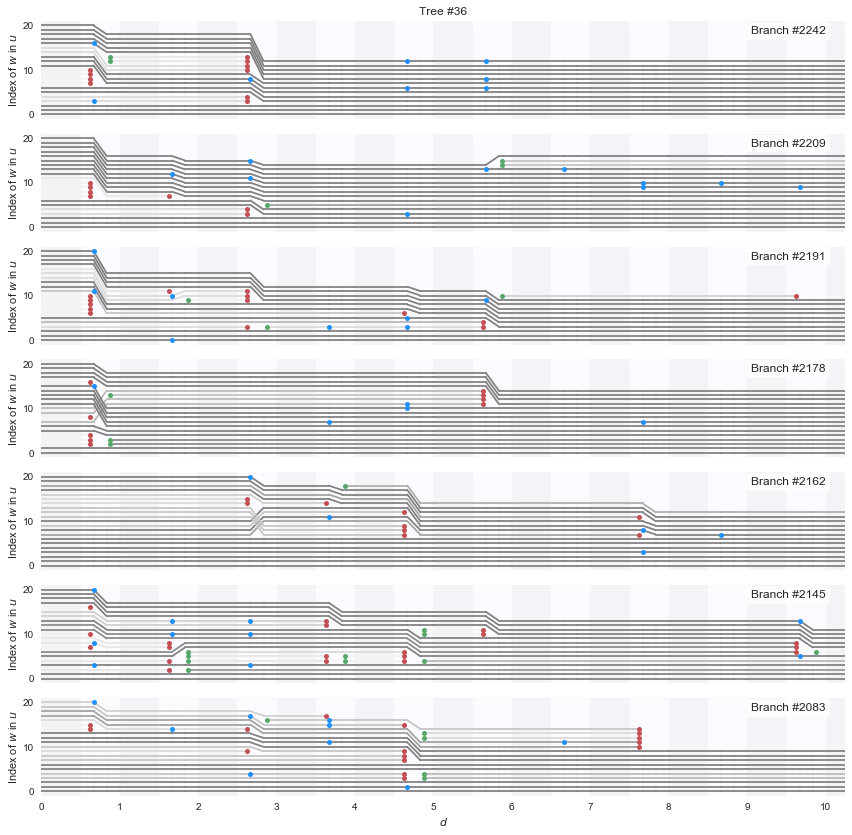

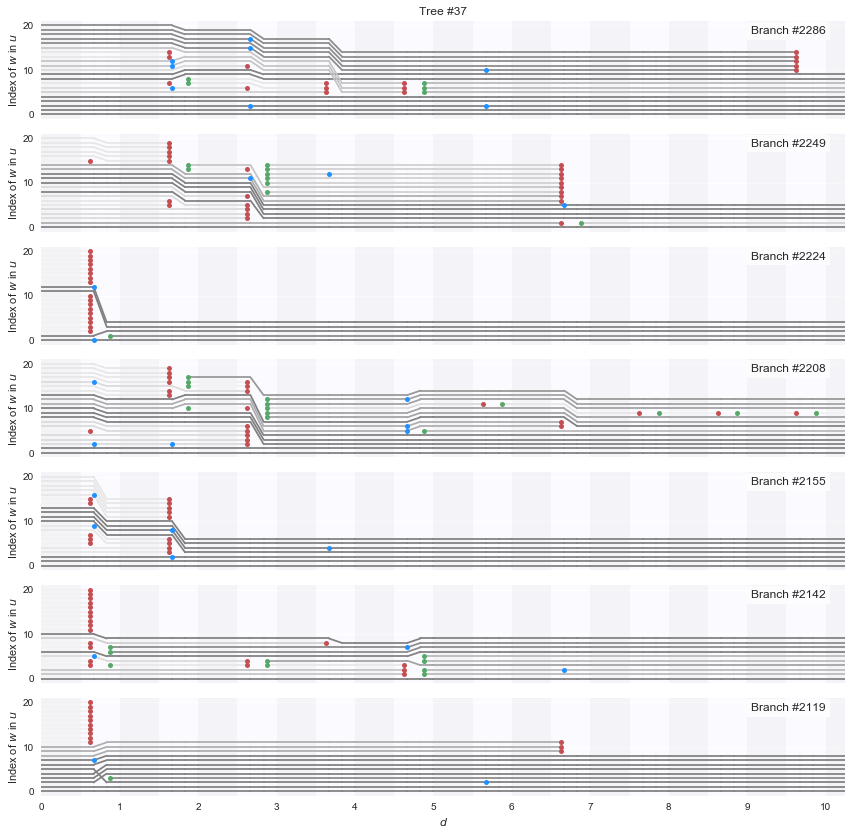

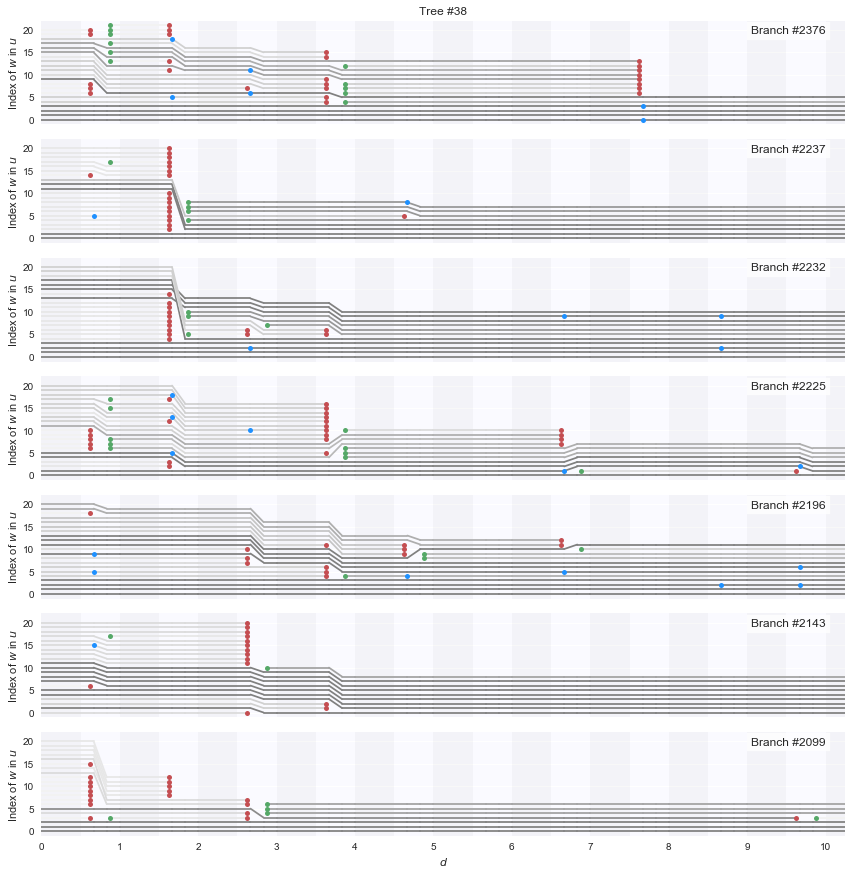

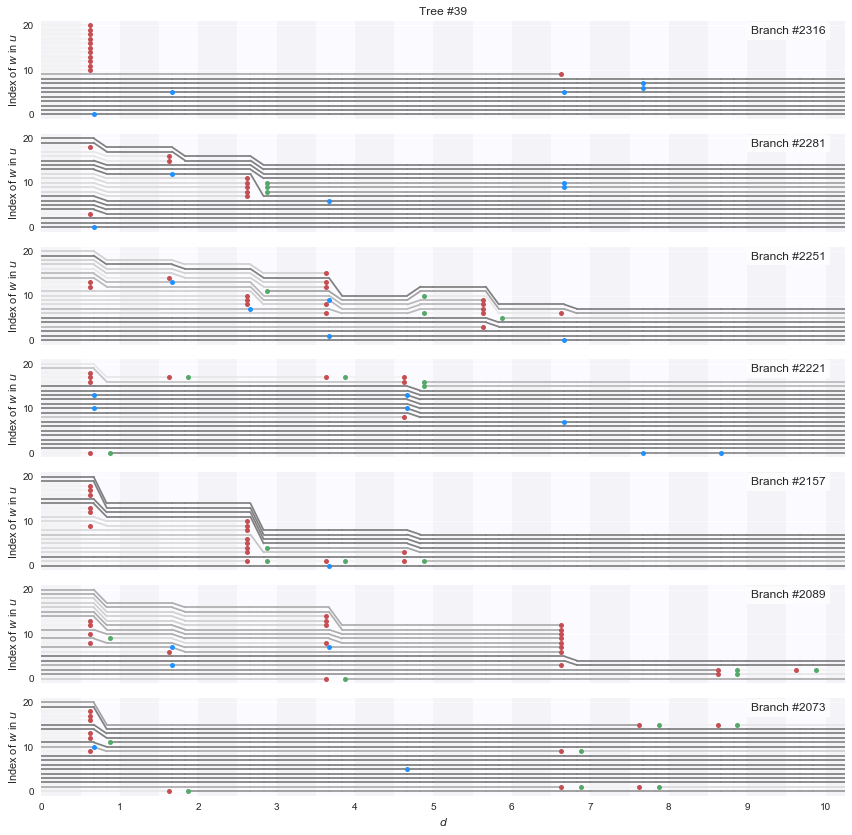

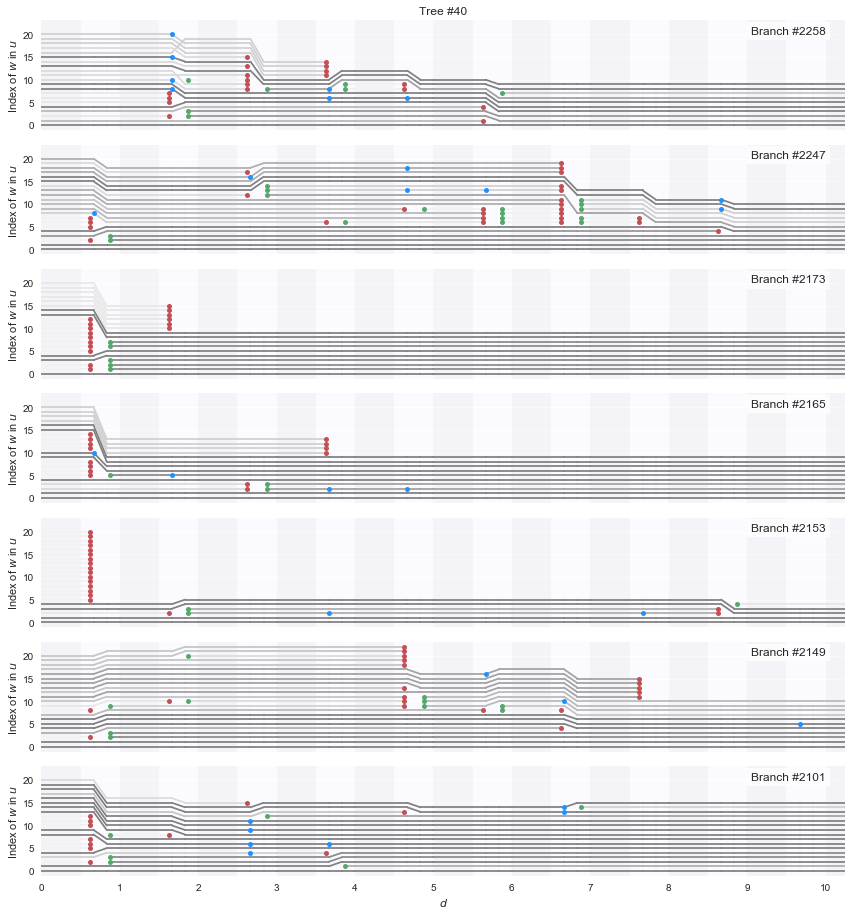

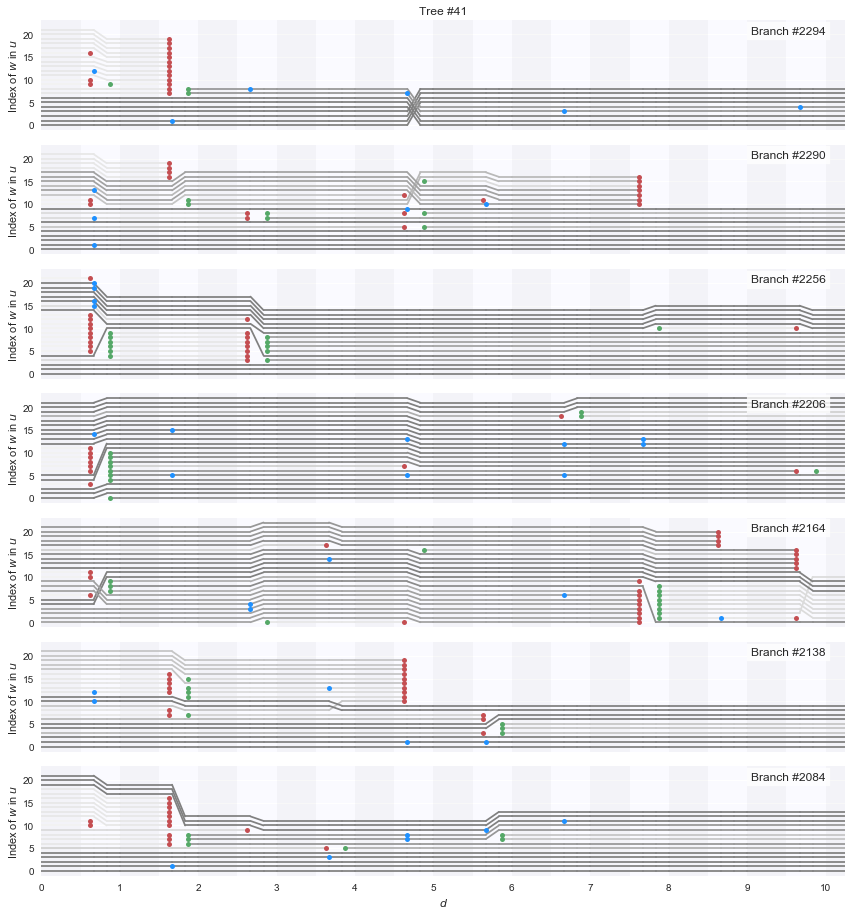

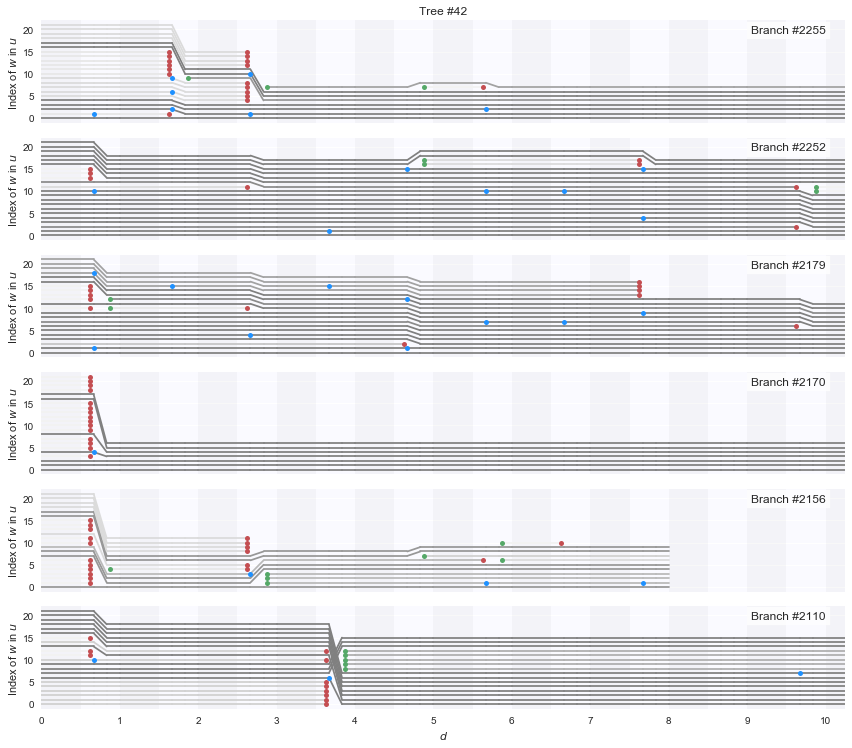

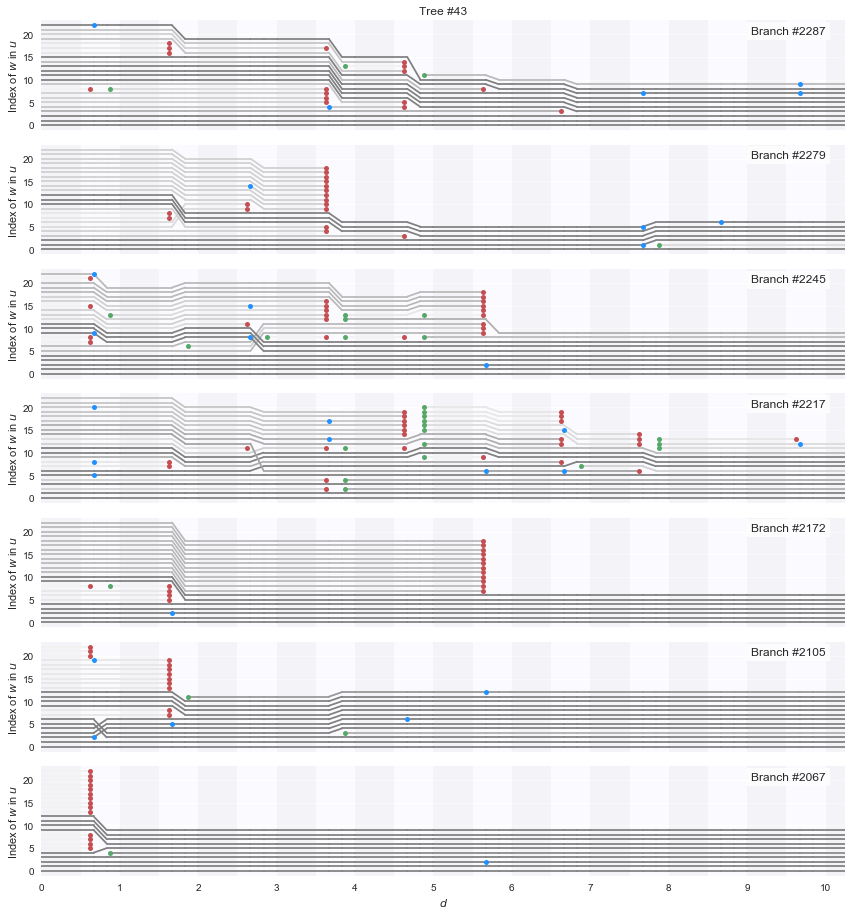

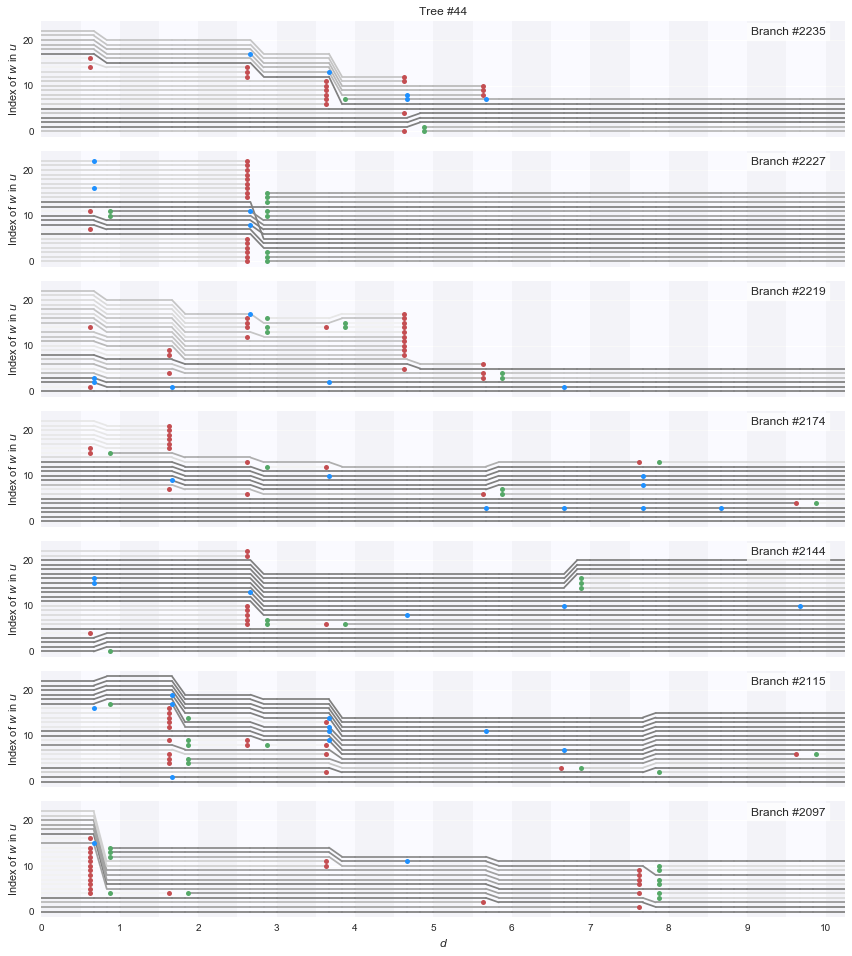

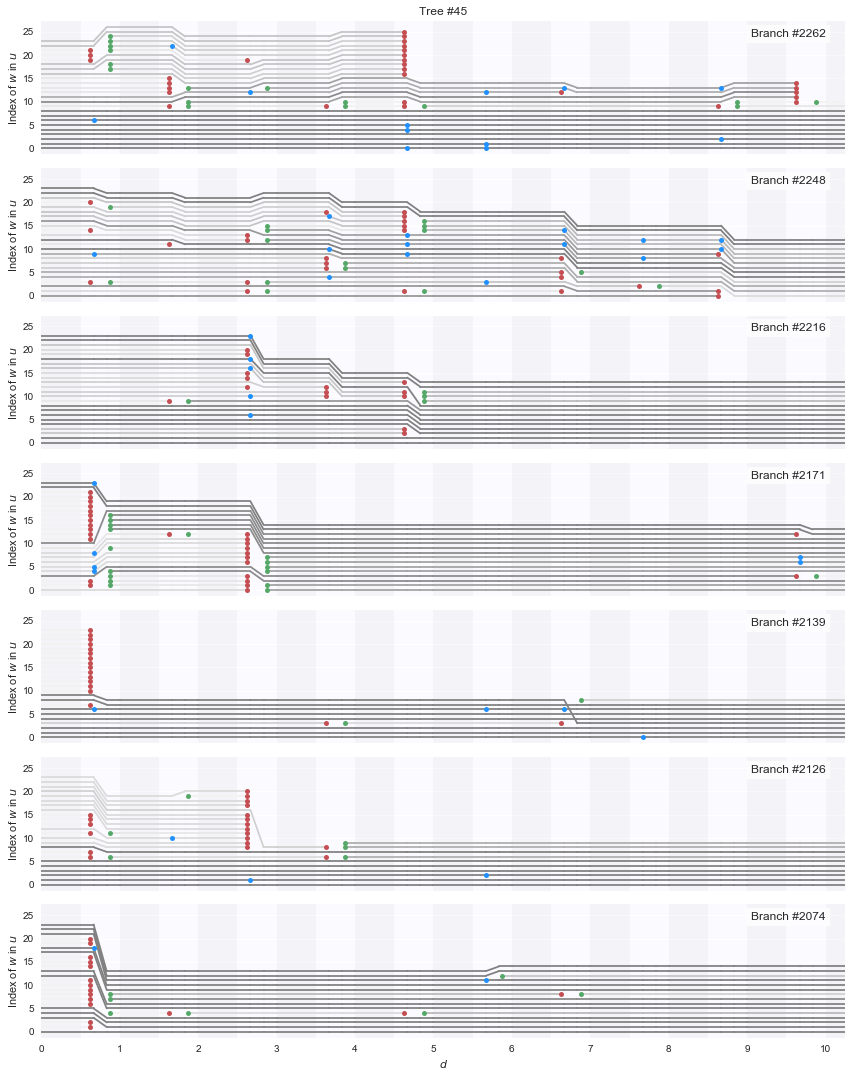

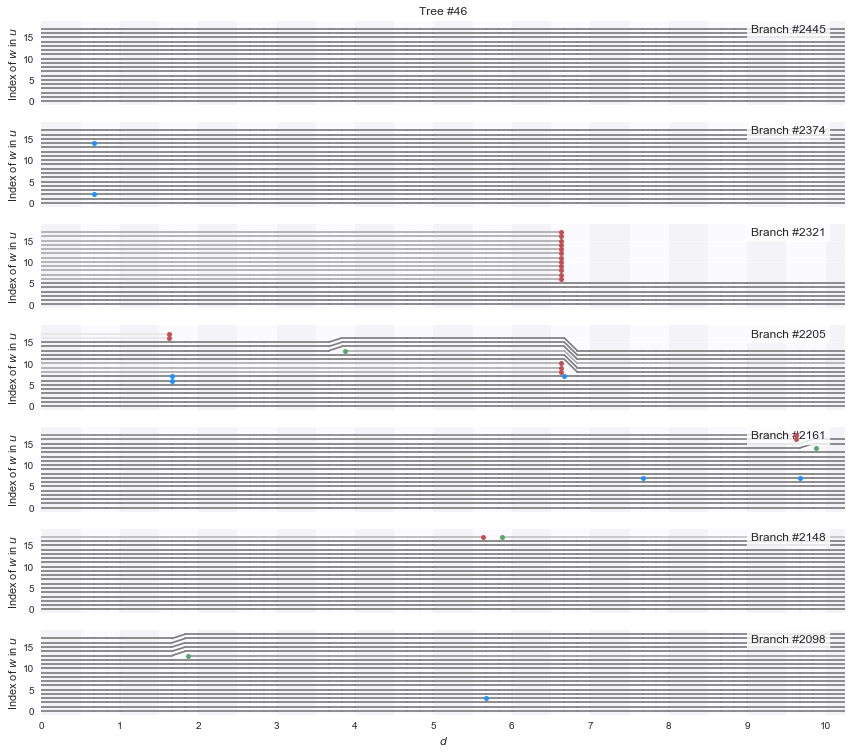

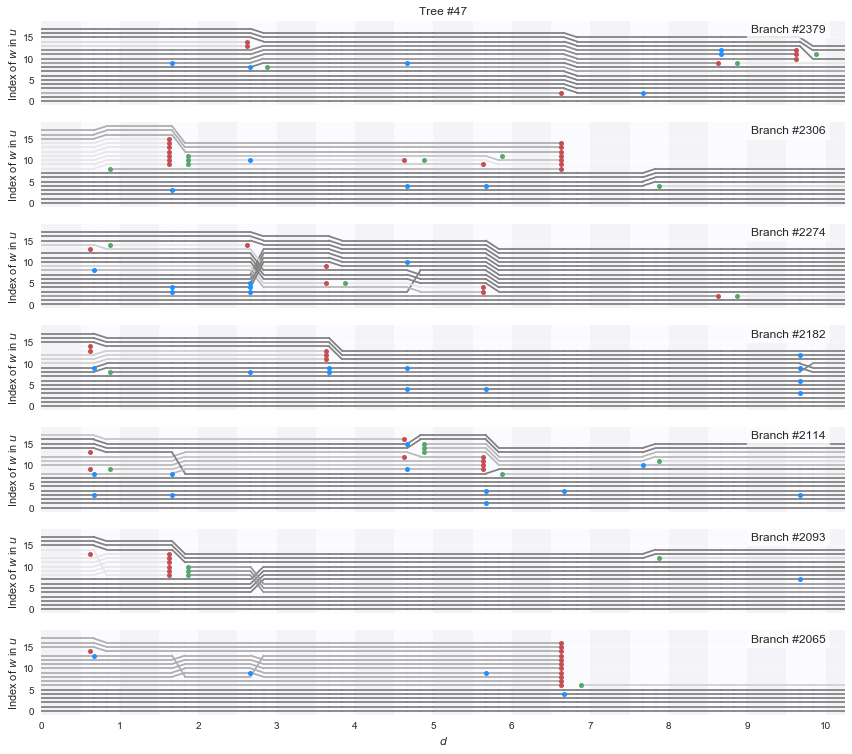

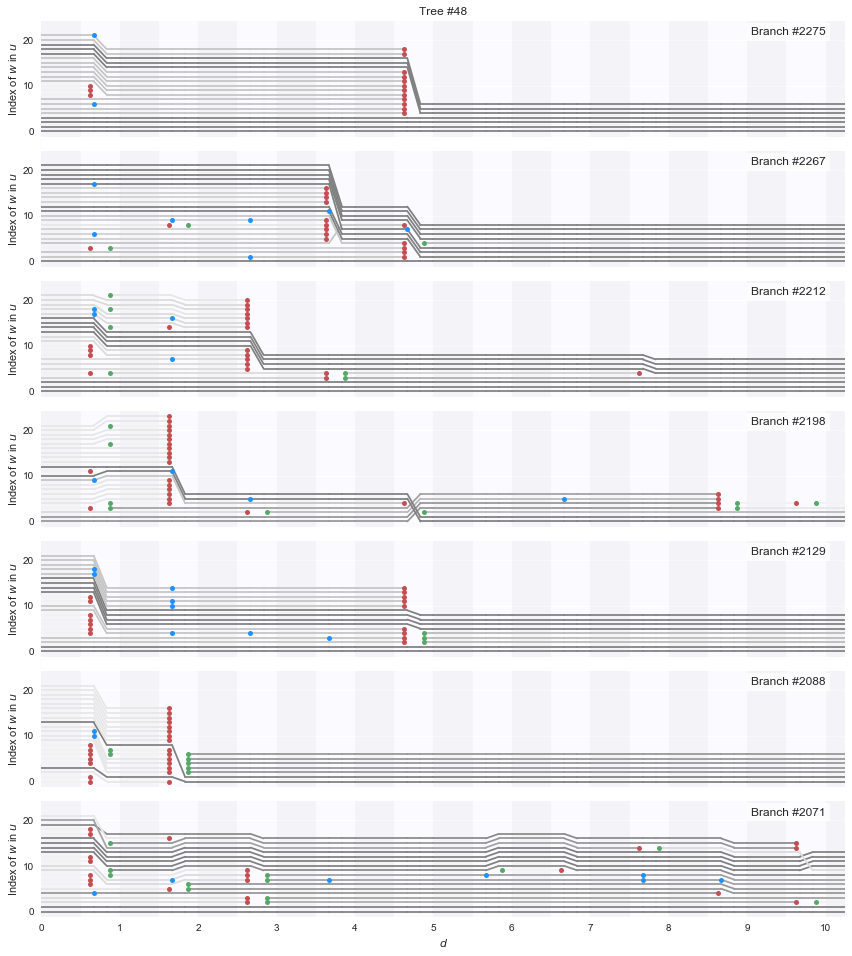

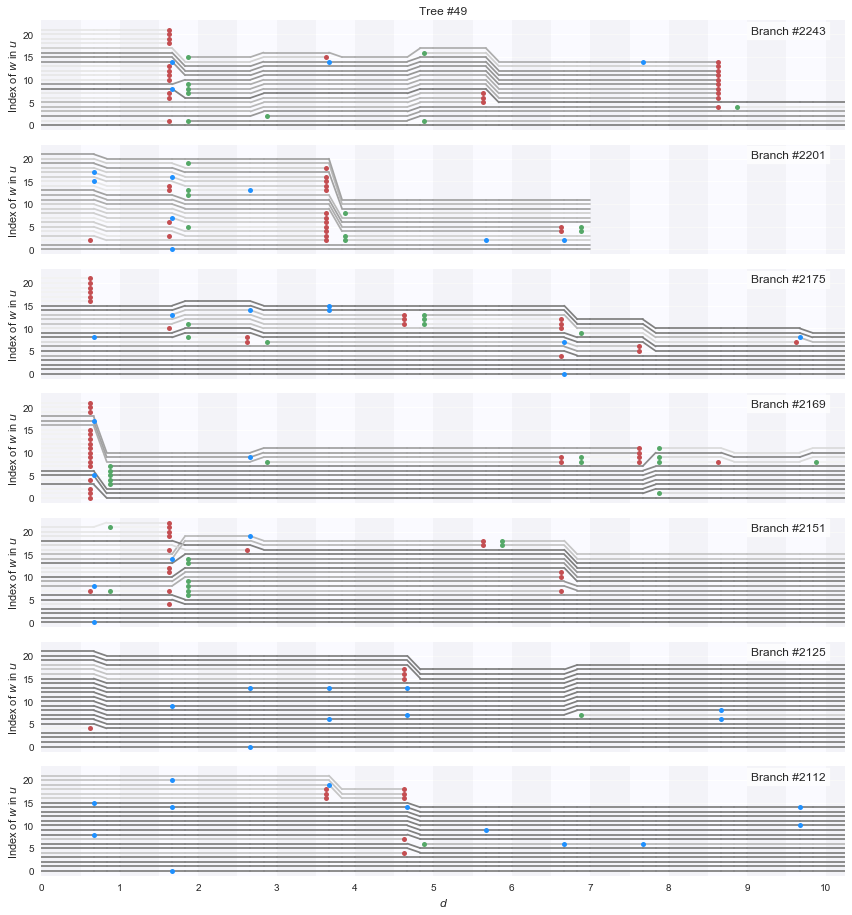

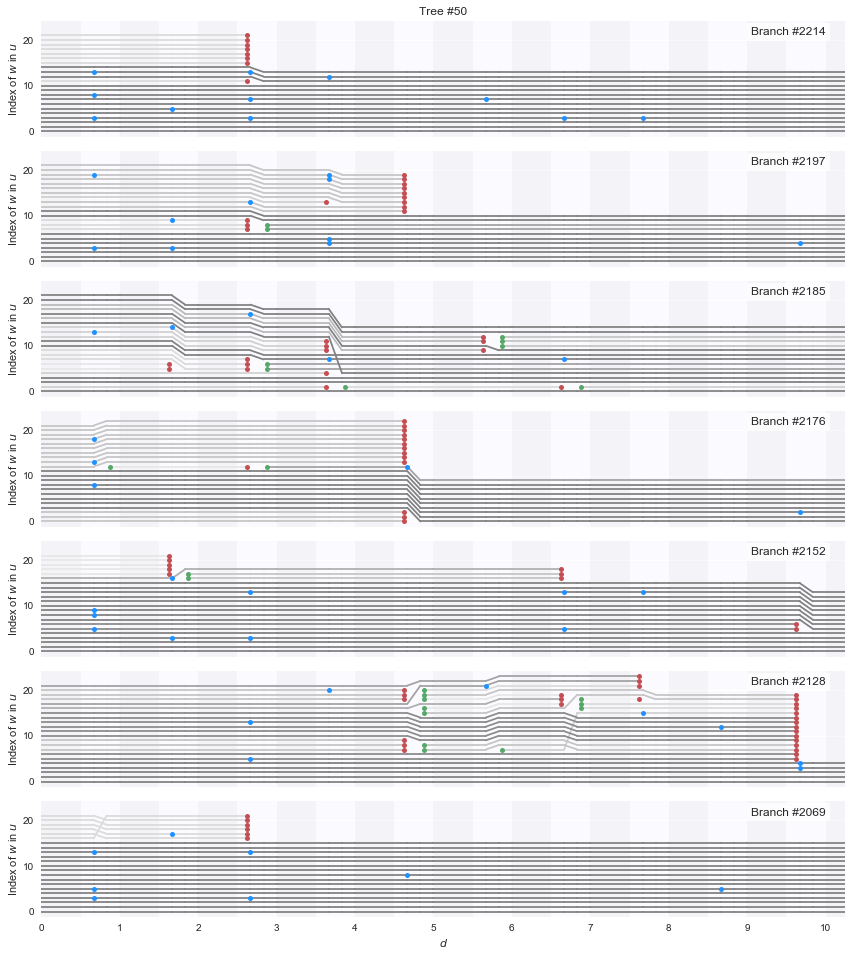

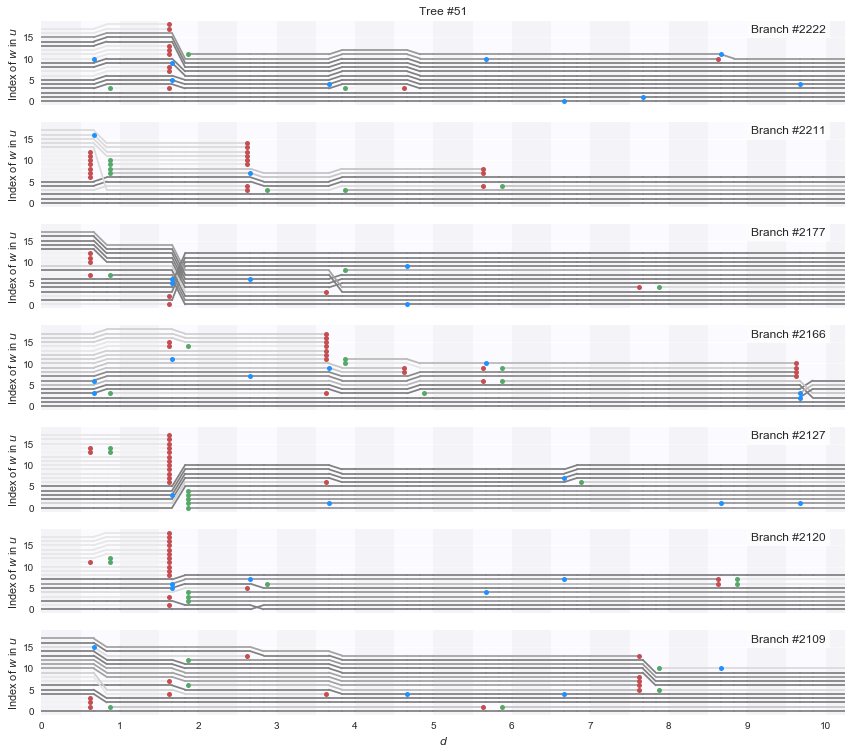

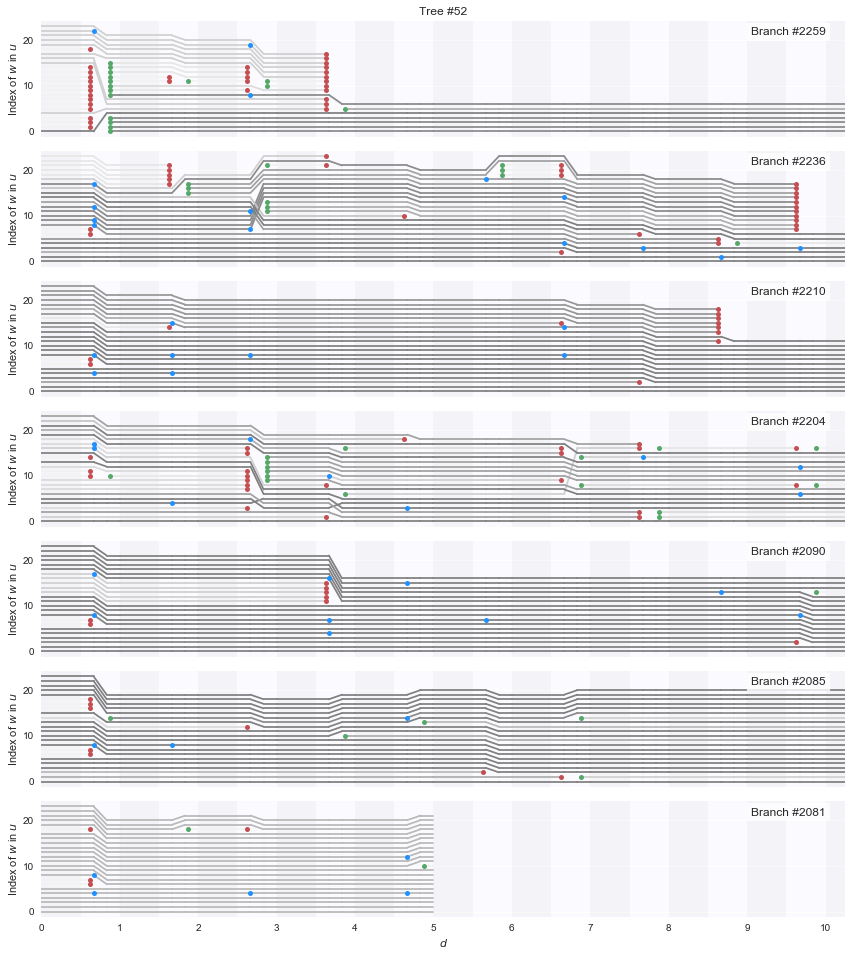

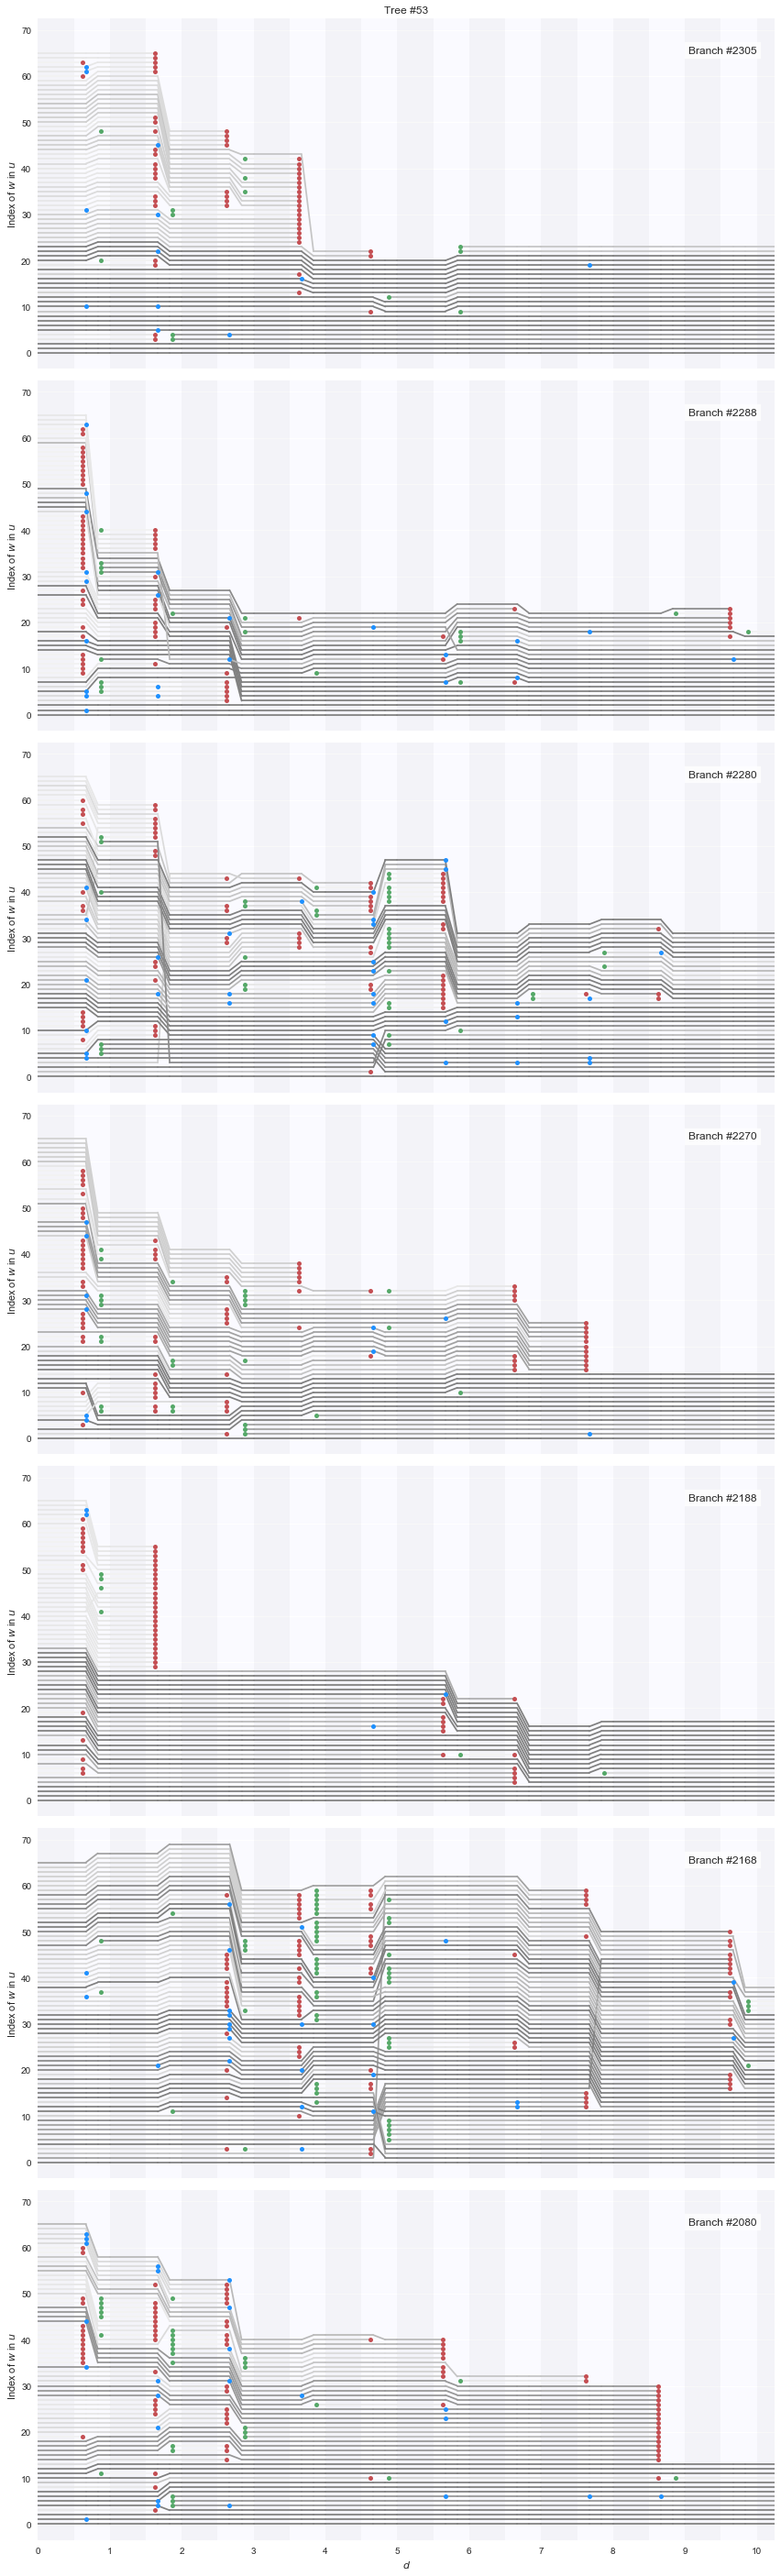

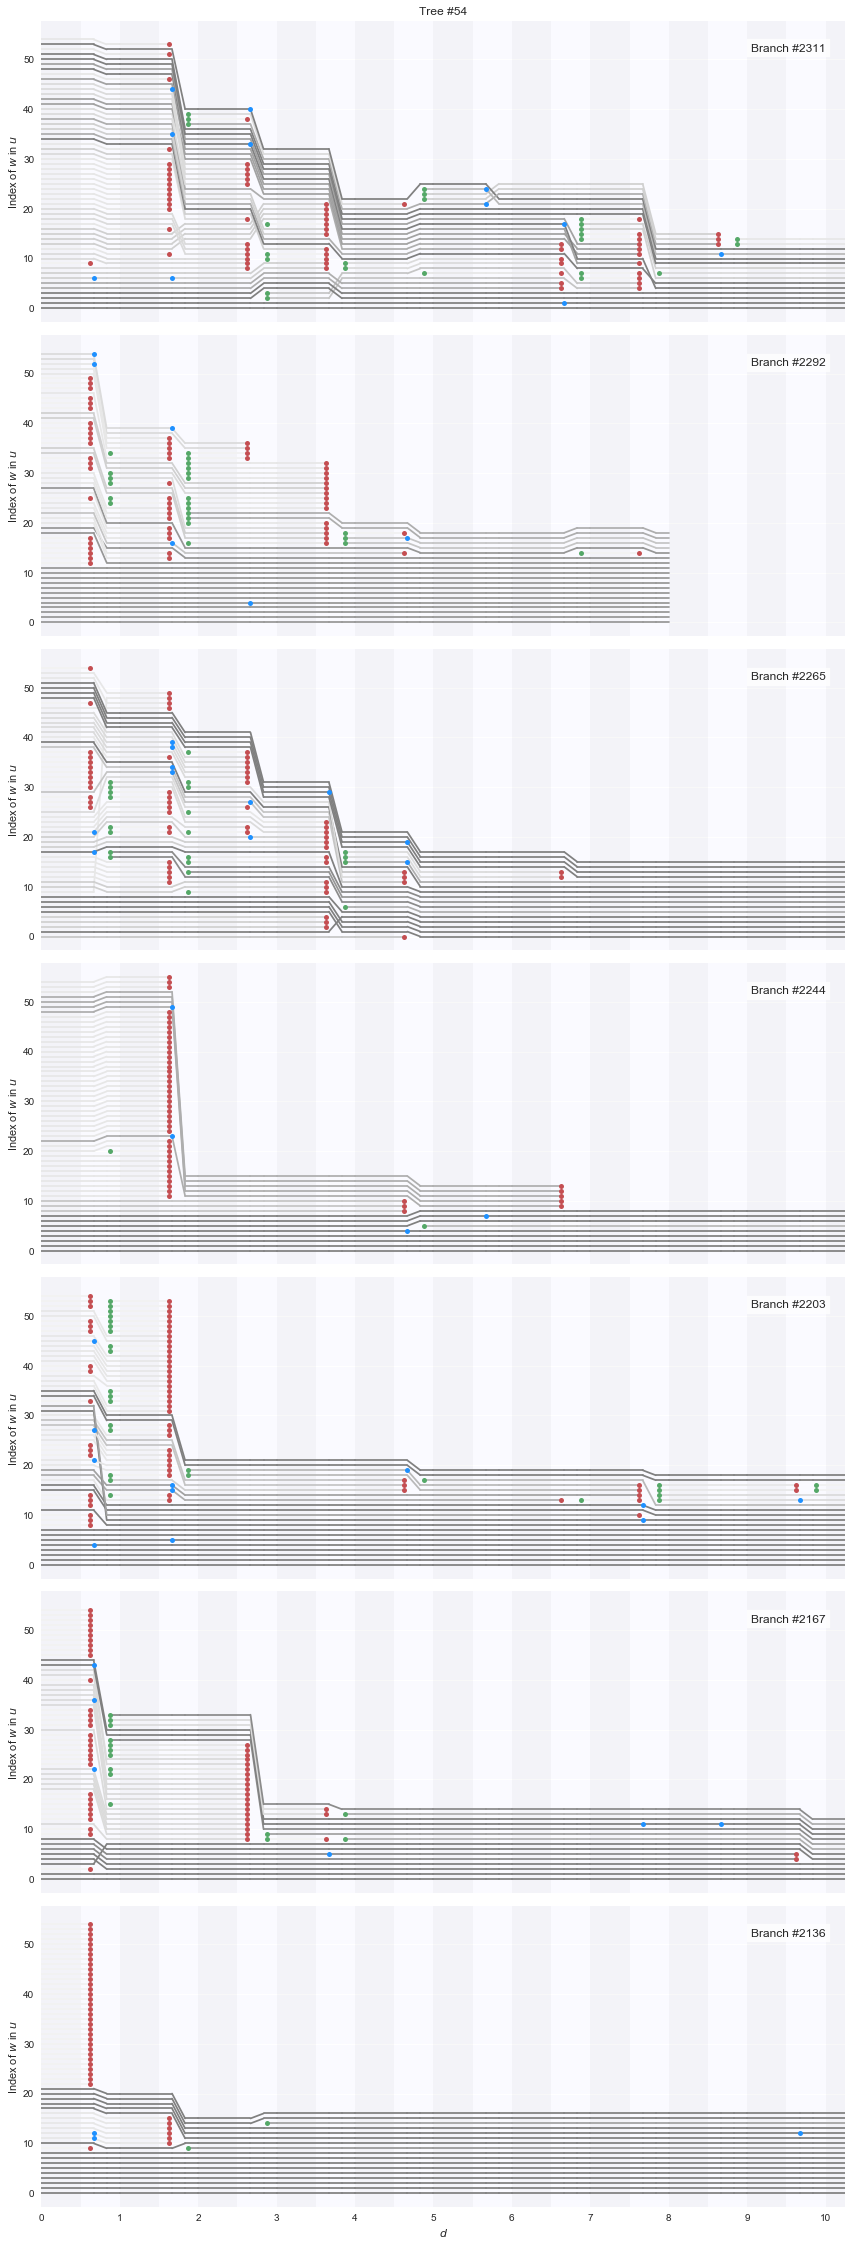

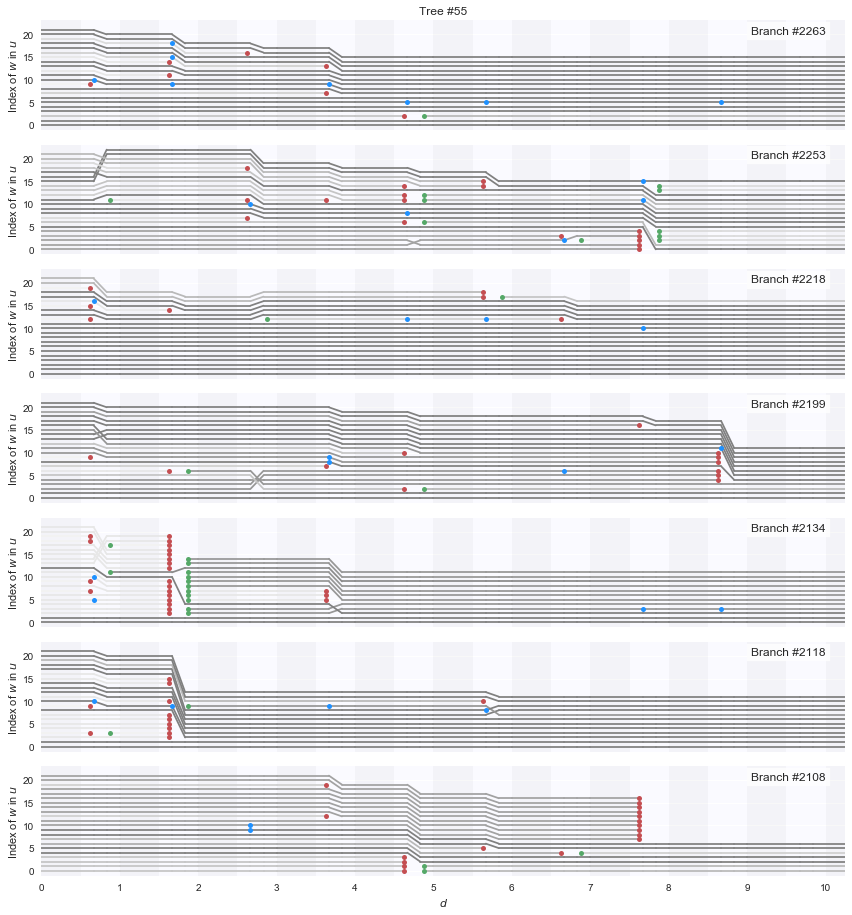

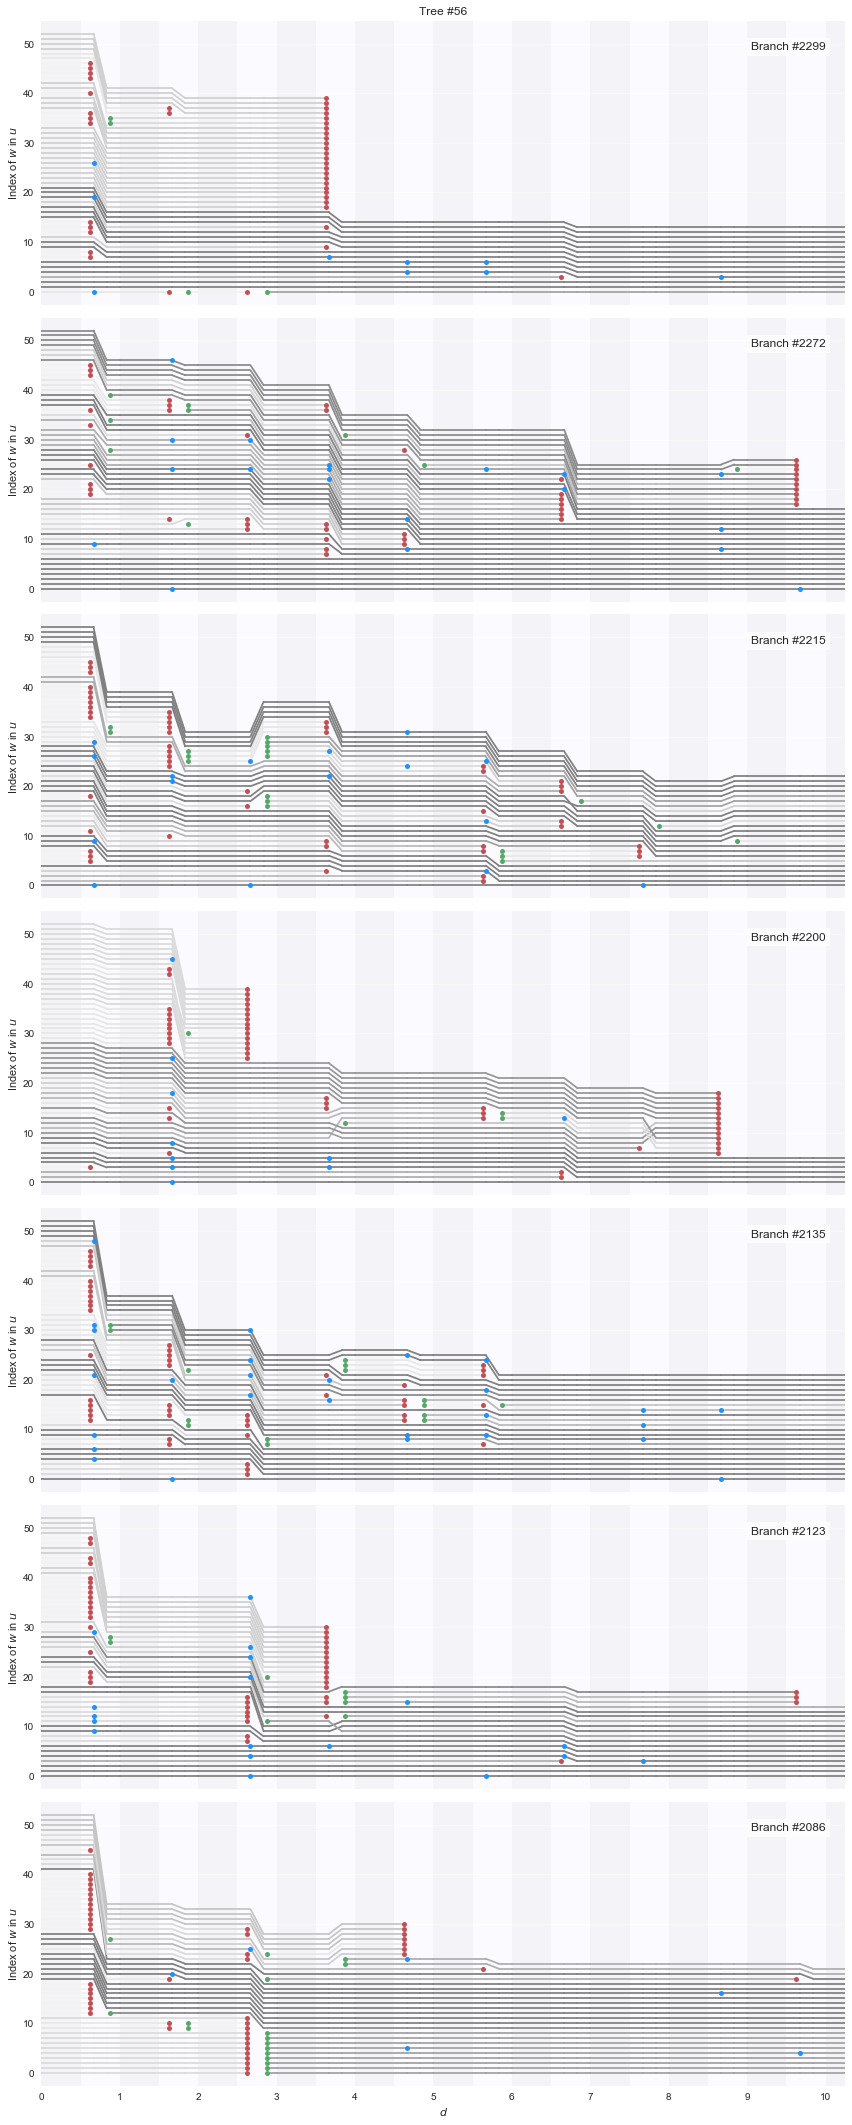

In [12]:
for tree_id in Tree.objects.experiment.values_list('id', flat=True):
    analysis.utils.Memoize.drop_caches()
    plot_tree(tree_id, branch_kws={'coloring': 'path_length'})